In [1895]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as pyplot
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
import os

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Setting to make numbers easier to read on display
pd.options.display.float_format = '{:20,.2f}'.format

#Show all columns on output
pd.set_option('display.max_columns', 999)


## Data Exploration

In [1652]:
#
df = pd.read_excel("../data/online_retail_II.xlsx", sheet_name=0)

df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,"13,085.00",United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,"13,085.00",United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,"13,085.00",United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,"13,085.00",United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,"13,085.00",United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,"13,085.00",United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,"13,085.00",United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,"13,085.00",United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,"13,085.00",United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,"13,085.00",United Kingdom


In [1892]:
try:
    # Get data with progress bar
    data = yf.download("GBPUSD=X", 
                      start="2009-12-01", 
                      end="2010-12-10",
                      progress=False)
    
    # Create clean series with proper name
    gbp_usd = data['Close'].copy()
    gbp_usd.name = "GBP_to_USD"
    
    # Forward-fill any missing dates (weekends/holidays)
    all_dates = pd.date_range(start='2009-12-01', end='2010-12-09')
    gbp_usd = gbp_usd.reindex(all_dates).ffill()
    
    print("Successfully retrieved rates:")
    print(gbp_usd.head())
    
except Exception as e:
    print(f"Error: {e}")
    print("\nFallback: Loading from pre-downloaded CSV")
    gbp_usd = pd.read_csv("gbp_usd_2009_2010.csv", 
                         index_col=0, 
                         parse_dates=True)['Rate']

Successfully retrieved rates:
Ticker                 GBPUSD=X
2009-12-01                 1.66
2009-12-02                 1.67
2009-12-03                 1.66
2009-12-04                 1.65
2009-12-05                 1.65


In [1894]:
# Define filename with timestamp
from datetime import datetime
filename = f"gbp_usd_rates_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"

# Save with additional options
gbp_usd.to_csv(
    filename,
    index=True,           # Save dates as a column
    header=['Rate'],      # Custom column name
    float_format='%.2f'   # Keep 4 decimal places
)

print(f"Successfully saved to: {filename}")

Successfully saved to: gbp_usd_rates_20250426_1949.csv


In [1896]:
old_name = 'gbp_usd_rates_20250426_1949.csv'
new_name = 'exchangerate.csv'

# Rename the file
try:
    os.rename(old_name, new_name)
    print(f"✅ Successfully renamed to {new_name}")
except FileNotFoundError:
    print(f"❌ Error: {old_name} not found in current directory")
except FileExistsError:
    print(f"❌ Error: {new_name} already exists")

✅ Successfully renamed to exchangerate.csv


In [2112]:
# 1. Load the CSV with headers
exchange_df = pd.read_csv('../data/exchangerate.csv', skiprows=1, header=None, names=['Date', 'Rate'])

# 2. Clean the data
exchange_df = exchange_df.dropna()  # Remove empty rows
exchange_df['Date'] = pd.to_datetime(exchange_df['Date']).dt.date

# 3. Verify
print(exchange_df.head())

# Verify the data (your original code)
print("First 5 rows:")
print(exchange_df.head())

print("\nData summary:")
print(exchange_df.describe())

         Date                 Rate
0  2009-12-01                 1.66
1  2009-12-02                 1.67
2  2009-12-03                 1.66
3  2009-12-04                 1.65
4  2009-12-05                 1.65
First 5 rows:
         Date                 Rate
0  2009-12-01                 1.66
1  2009-12-02                 1.67
2  2009-12-03                 1.66
3  2009-12-04                 1.65
4  2009-12-05                 1.65

Data summary:
                      Rate
count               374.00
mean                  1.55
std                   0.05
min                   1.43
25%                   1.52
50%                   1.56
75%                   1.59
max                   1.67


In [1902]:
# Quick summary of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   CustomerID   417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [2113]:
# Rename the column 'Customer ID' to 'CustomerID'
df = df.rename(columns={'Customer ID': 'CustomerID'})

In [2114]:
# Statistical summary of the DataFrame
df.describe()

,Quantity,InvoiceDate,Price,CustomerID
count,"525,461.00",525461,"525,461.00","417,534.00"
mean,10.34,2010-06-28 11:37:36.845017856,4.69,"15,360.65"
min,"-9,600.00",2009-12-01 07:45:00,"-53,594.36","12,346.00"
25%,1.00,2010-03-21 12:20:00,1.25,"13,983.00"
50%,3.00,2010-07-06 09:51:00,2.10,"15,311.00"
75%,10.00,2010-10-15 12:45:00,4.21,"16,799.00"
max,"19,152.00",2010-12-09 20:01:00,"25,111.09","18,287.00"
std,107.42,NaN,146.13,"1,680.81"


In [2115]:
# Summary of only the object-type (text/string) columns in DataFrame
df.describe(include='O')

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


In [1905]:
# Check for missing values in Customer ID column
df[df['CustomerID'].isna()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


In [1906]:
df['Country'].isna().sum()

np.int64(0)

In [1909]:
# Display the first 10 rows where Quantity is negative
df[df["Quantity"] < 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,"16,321.00",Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,"16,321.00",Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,"16,321.00",Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,"16,321.00",Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,"16,321.00",Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,"16,321.00",Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,"16,321.00",Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,"16,321.00",Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,"16,321.00",Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,"17,592.00",United Kingdom


In [1910]:
# convert the values in the 'Invoice' column to strings
df["Invoice"] = df["Invoice"].astype("str")
# Check whether each value in the 'Invoice' column matches exactly six digits,
# and filter out the values that do not match that 6-digit pattern.
# ^ means the start of the string | \d{6} means exactly 6 digits | $ means the end of the string
df[df["Invoice"].str.match("^\\d{6}$") == False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,"16,321.00",Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,"16,321.00",Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,"16,321.00",Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,"16,321.00",Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,"16,321.00",Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,"12,605.00",Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,"15,329.00",United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,"15,329.00",United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,"15,329.00",United Kingdom


In [1911]:
# Matches and replaces all digits (0 through 9) in the 'Invoice' values with an empty string — effectively removing all numbers from each invoice value
# and returns the unique values that remain.
# This will help identify any non-standard invoice formats or characters.
# The regex pattern "[0-9]" matches any digit, and the `regex=True` argument specifies that the replacement should be done using regex.
df["Invoice"].str.replace("[0-9]", "", regex=True).unique()

array(['', 'C', 'A'], dtype=object)

In [1912]:
df[df["Invoice"].str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,"-53,594.36",NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,"-44,031.79",NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,"-38,925.87",NaN,United Kingdom


In [1913]:
df["StockCode"] = df["StockCode"].astype("str")
# Filtering out rows where the StockCode is not exactly 5 digits AND not a combination of 5 digits followed by letters.
# This will help identify any non-standard stock codes or formats.
# The regex pattern "^\\d{5}$" matches exactly 5 digits, and the pattern "^\\d{5}[a-zA-Z]+$" matches 5 digits followed by one or more letters.
df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique()

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

In [1914]:
df[df["StockCode"].str.contains("POST")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.00,"12,682.00",France
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,"12,636.00",USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.00,"12,362.00",Belgium
625,489526,POST,POSTAGE,6,2009-12-01 11:50:00,18.00,"12,533.00",Germany
927,C489538,POST,POSTAGE,-1,2009-12-01 12:18:00,9.58,"15,796.00",United Kingdom
...,...,...,...,...,...,...,...,...
522916,537967,POST,POSTAGE,1,2010-12-09 11:31:00,18.00,"12,494.00",France
522930,537995,POST,POSTAGE,2,2010-12-09 11:39:00,18.00,"12,712.00",Germany
522974,538003,POST,POSTAGE,8,2010-12-09 12:05:00,18.00,"12,429.00",Denmark
523064,538008,POST,POSTAGE,5,2010-12-09 12:17:00,18.00,"12,683.00",France


In [1915]:
df[df["StockCode"].str.contains("D")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
197,C489459,90200D,PINK SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,"17,592.00",United Kingdom
204,C489459,90003D,CRYSTAL PAIR HEART HAIR SLIDES,-3,2009-12-01 10:44:00,3.75,"17,592.00",United Kingdom
208,C489459,90082D,DIAMANTE BOW BROOCH BLACK COLOUR,-2,2009-12-01 10:44:00,6.35,"17,592.00",United Kingdom
244,489462,90200D,PINK SWEETHEART BRACELET,3,2009-12-01 10:49:00,4.25,"17,592.00",United Kingdom
258,489462,90003D,CRYSTAL PAIR HEART HAIR SLIDES,3,2009-12-01 10:49:00,3.75,"17,592.00",United Kingdom
...,...,...,...,...,...,...,...,...
525147,538154,DOT,DOTCOM POSTAGE,1,2010-12-09 16:35:00,85.79,NaN,United Kingdom
525148,538155,84849D,HOT BATHS SOAP HOLDER,1,2010-12-09 16:52:00,1.69,"16,907.00",United Kingdom
525201,538156,17107D,"FLOWER FAIRY,5 SUMMER B'DRAW LINERS",10,2010-12-09 16:53:00,2.55,"15,555.00",United Kingdom
525325,538167,47591D,PINK FAIRY CAKE CHILDRENS APRON,2,2010-12-09 18:58:00,1.95,"14,713.00",United Kingdom


In [1916]:
df[df["StockCode"].str.contains("DCGS0058")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
2377,489597,DCGS0058,MISO PRETTY GUM,1,2009-12-01 14:28:00,0.83,NaN,United Kingdom
8372,490074,DCGS0058,MISO PRETTY GUM,1,2009-12-03 14:39:00,0.83,NaN,United Kingdom
17264,490745,DCGS0058,MISO PRETTY GUM,1,2009-12-07 18:02:00,0.83,NaN,United Kingdom
30671,491969,DCGS0058,MISO PRETTY GUM,1,2009-12-14 17:57:00,0.83,NaN,United Kingdom
31652,491970,DCGS0058,MISO PRETTY GUM,1,2009-12-14 18:03:00,0.83,NaN,United Kingdom
32045,491971,DCGS0058,MISO PRETTY GUM,2,2009-12-14 18:37:00,0.83,NaN,United Kingdom
34668,492303,DCGS0058,MISO PRETTY GUM,1,2009-12-16 11:57:00,0.83,NaN,United Kingdom
37222,492425,DCGS0058,MISO PRETTY GUM,1,2009-12-16 17:58:00,0.83,NaN,United Kingdom
40878,492782,DCGS0058,MISO PRETTY GUM,1,2009-12-18 17:06:00,0.83,NaN,United Kingdom
41260,492783,DCGS0058,MISO PRETTY GUM,2,2009-12-18 17:15:00,0.83,NaN,United Kingdom


In [1917]:
df[df["StockCode"].str.contains("DCGS0068")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
2378,489597,DCGS0068,DOGS NIGHT COLLAR,1,2009-12-01 14:28:00,8.65,NaN,United Kingdom
62734,494918,DCGS0068,DOGS NIGHT COLLAR,1,2010-01-19 17:49:00,8.47,NaN,United Kingdom


In [1918]:
df[df["StockCode"].str.contains("DOT")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
2379,489597,DOT,DOTCOM POSTAGE,1,2009-12-01 14:28:00,647.19,NaN,United Kingdom
2539,489600,DOT,DOTCOM POSTAGE,1,2009-12-01 14:43:00,55.96,NaN,United Kingdom
2551,489601,DOT,DOTCOM POSTAGE,1,2009-12-01 14:44:00,68.39,NaN,United Kingdom
2571,489602,DOT,DOTCOM POSTAGE,1,2009-12-01 14:45:00,59.35,NaN,United Kingdom
2619,489603,DOT,DOTCOM POSTAGE,1,2009-12-01 14:46:00,42.39,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524272,538071,DOT,DOTCOM POSTAGE,1,2010-12-09 14:09:00,885.94,NaN,United Kingdom
524887,538148,DOT,DOTCOM POSTAGE,1,2010-12-09 16:26:00,547.32,NaN,United Kingdom
525000,538149,DOT,DOTCOM POSTAGE,1,2010-12-09 16:27:00,620.68,NaN,United Kingdom
525126,538153,DOT,DOTCOM POSTAGE,1,2010-12-09 16:31:00,822.94,NaN,United Kingdom


In [1919]:
df[df["StockCode"].str.contains("M")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
1857,489594,79302M,"ART LIGHTS,FUNK MONKEY",1,2009-12-01 14:19:00,2.95,"15,005.00",United Kingdom
2697,489609,M,Manual,1,2009-12-01 14:50:00,4.00,NaN,United Kingdom
2845,489617,46000M,POLYESTER FILLER PAD 45x45cm,4,2009-12-01 14:59:00,1.55,"13,442.00",United Kingdom
3053,C489651,M,Manual,-1,2009-12-01 16:48:00,5.10,"17,804.00",United Kingdom
4366,489810,46000M,POLYESTER FILLER PAD 45x45cm,4,2009-12-02 12:47:00,1.55,"18,108.00",United Kingdom
...,...,...,...,...,...,...,...,...
521487,537823,16168M,FUNKY MONKEY GIFT BAG MEDIUM,1,2010-12-08 14:25:00,0.85,NaN,United Kingdom
522185,537850,16168M,FUNKY MONKEY GIFT BAG MEDIUM,24,2010-12-08 15:38:00,0.42,"16,722.00",United Kingdom
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,"15,329.00",United Kingdom
524776,538147,M,Manual,1,2010-12-09 16:11:00,15.00,"13,090.00",United Kingdom


In [1920]:
df[df["StockCode"].str.contains("DCGS0004")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
8371,490074,DCGS0004,HAYNES CAMPER SHOULDER BAG,1,2009-12-03 14:39:00,17.35,NaN,United Kingdom
98951,498699,DCGS0004,NaN,-2,2010-02-22 12:32:00,0.00,NaN,United Kingdom
164723,504935,DCGS0004,HAYNES CAMPER SHOULDER BAG,1,2010-04-19 11:19:00,16.98,NaN,United Kingdom
401083,527789,DCGS0004,HAYNES CAMPER SHOULDER BAG,1,2010-10-19 11:10:00,16.98,NaN,United Kingdom


In [1921]:
df[df["StockCode"].str.contains("DCGS0076")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
8373,490074,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2009-12-03 14:39:00,16.48,NaN,United Kingdom
16426,490741,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2009-12-07 17:56:00,16.48,NaN,United Kingdom
17265,490745,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2009-12-07 18:02:00,16.48,NaN,United Kingdom
20324,491043,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2009-12-09 09:51:00,16.48,NaN,United Kingdom
30673,491969,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2009-12-14 17:57:00,16.48,NaN,United Kingdom
69630,495574,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2010-01-25 17:36:00,16.13,NaN,United Kingdom
87575,497590,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2010-02-10 17:59:00,16.13,NaN,United Kingdom
118446,500695,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2010-03-09 12:48:00,16.13,NaN,United Kingdom
169935,505510,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,2,2010-04-22 14:33:00,16.13,NaN,United Kingdom
212437,509972,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2010-05-26 13:34:00,16.13,NaN,United Kingdom


In [1922]:
df[df["StockCode"].str.contains("C2")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
9292,490127,C2,CARRIAGE,1,2009-12-03 18:13:00,50.00,"14,156.00",EIRE
14481,490541,C2,CARRIAGE,1,2009-12-07 09:25:00,50.00,NaN,EIRE
14502,490542,C2,CARRIAGE,1,2009-12-07 09:42:00,50.00,"14,911.00",EIRE
19541,490998,C2,CARRIAGE,1,2009-12-08 17:24:00,50.00,"16,253.00",United Kingdom
22803,491160,C2,CARRIAGE,1,2009-12-10 10:29:00,50.00,"14,911.00",EIRE
...,...,...,...,...,...,...,...,...
504361,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,"14,911.00",EIRE
515057,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.00,"14,911.00",EIRE
515390,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.00,"14,911.00",EIRE
522913,537963,C2,CARRIAGE,1,2010-12-09 11:30:00,50.00,"13,369.00",United Kingdom


In [1923]:
df[df["StockCode"].str.contains("BANK CHARGES")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
18410,C490943,BANK CHARGES,Bank Charges,-1,2009-12-08 14:08:00,15.00,"16,703.00",United Kingdom
18466,490948,BANK CHARGES,Bank Charges,1,2009-12-08 14:29:00,15.00,"16,805.00",United Kingdom
33435,C492206,BANK CHARGES,Bank Charges,-1,2009-12-15 16:32:00,848.43,NaN,United Kingdom
55948,C494438,BANK CHARGES,Bank Charges,-1,2010-01-14 12:15:00,767.99,NaN,United Kingdom
94431,498269,BANK CHARGES,Bank Charges,1,2010-02-17 15:03:00,15.00,"16,928.00",United Kingdom
...,...,...,...,...,...,...,...,...
450634,C532203,BANK CHARGES,Bank Charges,-1,2010-11-11 12:31:00,15.00,NaN,United Kingdom
455268,532637,BANK CHARGES,Bank Charges,1,2010-11-12 16:18:00,15.00,"13,174.00",United Kingdom
493162,535474,BANK CHARGES,Bank Charges,1,2010-11-26 13:56:00,15.00,"16,928.00",United Kingdom
507344,536779,BANK CHARGES,Bank Charges,1,2010-12-02 15:08:00,15.00,"15,823.00",United Kingdom


In [1924]:
df[df["StockCode"].str.contains("DCGS0003")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
20249,491041,DCGS0003,BOXED GLASS ASHTRAY,1,2009-12-09 09:42:00,2.57,NaN,United Kingdom
232222,511858,DCGS0003,BOXED GLASS ASHTRAY,1,2010-06-11 10:05:00,2.51,NaN,United Kingdom
238355,512437,DCGS0003,BOXED GLASS ASHTRAY,1,2010-06-15 16:17:00,2.51,NaN,United Kingdom
244829,513099,DCGS0003,BOXED GLASS ASHTRAY,1,2010-06-21 15:13:00,2.51,NaN,United Kingdom
267418,515287,DCGS0003,BOXED GLASS ASHTRAY,1,2010-07-09 14:58:00,2.51,NaN,United Kingdom
421518,529727,DCGS0003,BOXED GLASS ASHTRAY,1,2010-10-29 14:12:00,2.51,NaN,United Kingdom
442200,531489,DCGS0003,BOXED GLASS ASHTRAY,1,2010-11-08 15:02:00,2.51,NaN,United Kingdom
466307,533348,DCGS0003,BOXED GLASS ASHTRAY,1,2010-11-17 09:23:00,2.51,NaN,United Kingdom
478086,534289,DCGS0003,BOXED GLASS ASHTRAY,1,2010-11-22 11:25:00,2.51,NaN,United Kingdom


In [1925]:
df[df["StockCode"].str.contains("TEST001")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.50,"12,346.00",United Kingdom
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.50,"12,346.00",United Kingdom
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.50,"12,346.00",United Kingdom
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.50,"12,346.00",United Kingdom
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,"12,346.00",United Kingdom
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,"12,346.00",United Kingdom
56117,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,4.50,"12,346.00",United Kingdom
66084,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,4.50,"12,346.00",United Kingdom
89084,497819,TEST001,This is a test product.,5,2010-02-12 14:58:00,0.00,"14,103.00",United Kingdom
89180,497843,TEST001,This is a test product.,5,2010-02-12 15:47:00,0.00,"14,827.00",United Kingdom


In [1926]:
df[df["StockCode"].str.contains("gift_0001_80")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
30620,491968,gift_0001_80,NaN,2,2009-12-14 17:56:00,0.00,NaN,United Kingdom
31079,491969,gift_0001_80,Dotcomgiftshop Gift Voucher £80.00,1,2009-12-14 17:57:00,69.56,NaN,United Kingdom
56446,C494472,gift_0001_80,Dotcomgiftshop Gift Voucher £80.00,-1,2010-01-14 14:51:00,69.56,NaN,United Kingdom
298842,518488,gift_0001_80,NaN,10,2010-08-09 12:29:00,0.00,NaN,United Kingdom


In [1927]:
df[df["StockCode"].str.contains("DCGS0072")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
30672,491969,DCGS0072,CAT CAMOUFLAGUE COLLAR,1,2009-12-14 17:57:00,5.17,NaN,United Kingdom
34669,492303,DCGS0072,CAT CAMOUFLAGUE COLLAR,2,2009-12-16 11:57:00,5.17,NaN,United Kingdom
41261,492783,DCGS0072,CAT CAMOUFLAGUE COLLAR,1,2009-12-18 17:15:00,5.17,NaN,United Kingdom


In [1928]:
df[df["StockCode"].str.contains("gift_0001_20")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
32048,491971,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,2,2009-12-14 18:37:00,17.39,NaN,United Kingdom
40905,492782,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2009-12-18 17:06:00,17.39,NaN,United Kingdom
45213,493404,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2009-12-23 15:30:00,17.39,NaN,United Kingdom
75097,496247,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2010-01-29 16:11:00,17.02,NaN,United Kingdom
96283,498443,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2010-02-19 09:49:00,17.02,NaN,United Kingdom
153282,503940,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2010-04-08 14:47:00,17.02,NaN,United Kingdom
181337,506577,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2010-04-30 13:45:00,17.02,NaN,United Kingdom
195555,508077,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2010-05-12 16:29:00,17.02,NaN,United Kingdom
254427,513946,gift_0001_20,NaN,5,2010-06-29 13:35:00,0.00,NaN,United Kingdom
265191,515013,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2010-07-07 16:29:00,17.02,NaN,United Kingdom


In [1929]:
df[df["StockCode"].str.contains("DCGS0044")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
33819,492226,DCGS0044,HANDZ-OFF CAR FRESHENER,1,2009-12-15 18:33:00,2.57,NaN,United Kingdom


In [1932]:
df[df["StockCode"].str.contains("TEST002")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.00,"12,346.00",United Kingdom
44614,493294,TEST002,NaN,1,2009-12-22 15:15:00,0.00,NaN,United Kingdom


In [1931]:
df[df["StockCode"].str.contains("gift_0001_10")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
40904,492782,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2009-12-18 17:06:00,8.69,NaN,United Kingdom
125922,501441,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2010-03-16 13:44:00,8.51,NaN,United Kingdom
136604,502486,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2010-03-24 17:43:00,8.51,NaN,United Kingdom
218754,510637,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2010-06-02 11:54:00,8.51,NaN,United Kingdom
298848,518496,gift_0001_10,NaN,10,2010-08-09 12:31:00,0.00,NaN,United Kingdom
352994,523696,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2010-09-23 14:47:00,8.51,NaN,United Kingdom
442201,531489,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00,1,2010-11-08 15:02:00,8.51,NaN,United Kingdom


In [1933]:
df[df["StockCode"].str.contains("gift_0001_50")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
41263,492783,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,2009-12-18 17:15:00,43.48,NaN,United Kingdom
75136,496249,gift_0001_50,NaN,3,2010-01-29 16:17:00,0.00,NaN,United Kingdom
298841,518491,gift_0001_50,NaN,10,2010-08-09 12:29:00,0.00,NaN,United Kingdom
376731,525755,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,2010-10-07 10:23:00,42.55,NaN,United Kingdom


In [1934]:
df[df["StockCode"].str.contains("DCGS0066N")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
44245,493265,DCGS0066N,NAVY CUDDLES DOG HOODIE,1,2009-12-22 15:05:00,8.65,NaN,United Kingdom
44335,493268,DCGS0066N,NaN,1,2009-12-22 15:07:00,0.00,NaN,United Kingdom
44377,493269,DCGS0066N,NAVY CUDDLES DOG HOODIE,1,2009-12-22 15:07:00,8.65,NaN,United Kingdom
44609,493289,DCGS0066N,NaN,1,2009-12-22 15:13:00,0.00,NaN,United Kingdom


In [1935]:
df[df["StockCode"].str.contains("gift_0001_30")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
45212,493404,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2009-12-23 15:30:00,26.08,NaN,United Kingdom
54564,494380,gift_0001_30,NaN,5,2010-01-13 17:39:00,0.00,NaN,United Kingdom
54636,494381,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2010-01-13 17:44:00,25.53,NaN,United Kingdom
66801,495343,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2010-01-22 18:05:00,25.53,NaN,United Kingdom
142163,502872,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2010-03-29 09:59:00,25.53,NaN,United Kingdom
164334,504933,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2010-04-19 11:13:00,25.53,NaN,United Kingdom
174432,505888,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2010-04-26 14:14:00,25.53,NaN,United Kingdom
174563,505935,gift_0001_30,NaN,3,2010-04-26 14:54:00,0.00,NaN,United Kingdom
181338,506577,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2010-04-30 13:45:00,25.53,NaN,United Kingdom
186882,507177,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2010-05-06 15:09:00,25.53,NaN,United Kingdom


In [1936]:
df[df["StockCode"].str.contains("PADS")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
62299,494914,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-19 17:04:00,0.00,"16,705.00",United Kingdom
74731,496222,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-01-29 13:53:00,0.00,"13,583.00",United Kingdom
77702,496473,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-01 15:38:00,0.00,"17,350.00",United Kingdom
79794,496643,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-03 11:58:00,0.00,"13,408.00",United Kingdom
90798,497935,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-15 10:47:00,0.00,"13,408.00",United Kingdom
97716,498562,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-21 12:03:00,0.00,"15,182.00",United Kingdom
101718,499056,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-24 13:46:00,0.00,"13,765.00",United Kingdom
104480,499399,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-02-26 13:26:00,0.00,"14,459.00",United Kingdom
123947,501176,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-03-15 11:00:00,0.00,"14,857.00",United Kingdom
156809,504332,PADS,PADS TO MATCH ALL CUSHIONS,1,2010-04-12 16:30:00,0.00,"12,671.00",Germany


In [1937]:
df[df["StockCode"].str.contains("ADJUST")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
70975,495732,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:20:00,96.46,NaN,EIRE
70976,495733,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:21:00,68.34,"14,911.00",EIRE
70977,495735,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,201.56,"12,745.00",EIRE
70978,495734,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,205.82,"14,911.00",EIRE
70979,C495737,ADJUST,Adjustment by john on 26/01/2010 16,-1,2010-01-26 16:23:00,10.50,"16,154.00",United Kingdom
...,...,...,...,...,...,...,...,...
208670,C509474,ADJUST,Adjustment by Peter on 24/05/2010 1,-1,2010-05-24 11:13:00,72.45,"16,422.00",United Kingdom
208671,C509475,ADJUST,Adjustment by Peter on 24/05/2010 1,-1,2010-05-24 11:13:00,358.47,"17,364.00",United Kingdom
249672,513564,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,300.13,"17,050.00",United Kingdom
249673,513566,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,358.47,"17,364.00",United Kingdom


In [1938]:
df[df["StockCode"].str.contains("gift_0001_40")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
75137,496248,gift_0001_40,NaN,3,2010-01-29 16:17:00,0.00,NaN,United Kingdom
298847,518492,gift_0001_40,NaN,10,2010-08-09 12:30:00,0.00,NaN,United Kingdom
299652,518579,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,2010-08-10 12:08:00,31.35,NaN,United Kingdom
407443,528382,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,2010-10-21 18:01:00,34.04,NaN,United Kingdom


In [1939]:
df[df["StockCode"].str.contains("gift_0001_60")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
75138,496250,gift_0001_60,NaN,3,2010-01-29 16:17:00,0.00,NaN,United Kingdom
298843,518490,gift_0001_60,NaN,10,2010-08-09 12:29:00,0.00,NaN,United Kingdom


In [1940]:
df[df["StockCode"].str.contains("gift_0001_60")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
75138,496250,gift_0001_60,NaN,3,2010-01-29 16:17:00,0.00,NaN,United Kingdom
298843,518490,gift_0001_60,NaN,10,2010-08-09 12:29:00,0.00,NaN,United Kingdom


In [1941]:
df[df["StockCode"].str.contains("gift_0001_70")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
75139,496251,gift_0001_70,NaN,2,2010-01-29 16:17:00,0.00,NaN,United Kingdom
235291,512168,gift_0001_70,Dotcomgiftshop Gift Voucher £70.00,1,2010-06-14 11:24:00,59.57,NaN,United Kingdom
298840,518489,gift_0001_70,NaN,10,2010-08-09 12:29:00,0.00,NaN,United Kingdom


In [1942]:
df[df["StockCode"].str.contains("gift_0001_90")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
75141,496252,gift_0001_90,NaN,2,2010-01-29 16:18:00,0.00,NaN,United Kingdom
298839,518487,gift_0001_90,NaN,10,2010-08-09 12:28:00,0.00,NaN,United Kingdom


In [1943]:
df[df["StockCode"].str.contains("DCGSSGIRL")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
80231,496722,DCGSSGIRL,NaN,-1,2010-02-03 14:04:00,0.00,NaN,United Kingdom
241372,512738,DCGSSGIRL,update,100,2010-06-17 14:11:00,0.00,NaN,United Kingdom
244831,513099,DCGSSGIRL,GIRLS PARTY BAG,3,2010-06-21 15:13:00,3.36,NaN,United Kingdom
246184,513200,DCGSSGIRL,GIRLS PARTY BAG,6,2010-06-22 16:28:00,3.36,NaN,United Kingdom
249938,513574,DCGSSGIRL,GIRLS PARTY BAG,1,2010-06-25 15:13:00,3.36,NaN,United Kingdom
251930,513655,DCGSSGIRL,GIRLS PARTY BAG,5,2010-06-28 10:02:00,3.36,NaN,United Kingdom
253997,513907,DCGSSGIRL,GIRLS PARTY BAG,1,2010-06-29 12:08:00,3.36,NaN,United Kingdom
385192,526405,DCGSSGIRL,GIRLS PARTY BAG,6,2010-10-11 13:53:00,3.36,NaN,United Kingdom
425616,530060,DCGSSGIRL,GIRLS PARTY BAG,2,2010-11-01 11:35:00,3.36,NaN,United Kingdom
427107,530140,DCGSSGIRL,GIRLS PARTY BAG,12,2010-11-01 16:45:00,3.36,NaN,United Kingdom


In [1944]:
df[df["StockCode"].str.contains("DCGS0006")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
80337,496740,DCGS0006,NaN,-1,2010-02-03 14:28:00,0.00,NaN,United Kingdom


In [1945]:
df[df["StockCode"].str.contains("DCGS0016")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
80338,496741,DCGS0016,NaN,-1,2010-02-03 14:29:00,0.00,NaN,United Kingdom


In [1946]:
df[df["StockCode"].str.contains("DCGS0027")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
80339,496742,DCGS0027,NaN,-1,2010-02-03 14:29:00,0.00,NaN,United Kingdom


In [1947]:
df[df["StockCode"].str.contains("DCGS0036")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
80342,496744,DCGS0036,NaN,-1,2010-02-03 14:35:00,0.00,NaN,United Kingdom


In [1948]:
df[df["StockCode"].str.contains("DCGS0039")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
80361,496746,DCGS0039,NaN,-1,2010-02-03 14:36:00,0.00,NaN,United Kingdom


In [1949]:
df[df["StockCode"].str.contains("DCGS0060")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
80953,496814,DCGS0060,NaN,-3,2010-02-04 09:46:00,0.00,NaN,United Kingdom


In [1950]:
df[df["StockCode"].str.contains("DCGS0056")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
81143,496855,DCGS0056,NaN,-4,2010-02-04 11:46:00,0.00,NaN,United Kingdom


In [1951]:
df[df["StockCode"].str.contains("DCGS0059")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
82846,496988,DCGS0059,NaN,-8,2010-02-05 11:21:00,0.00,NaN,United Kingdom


In [1952]:
df[df["StockCode"].str.contains("GIFT")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
83304,497107,GIFT,NaN,-9,2010-02-05 15:18:00,0.00,NaN,United Kingdom


In [1953]:
df[df["StockCode"].str.contains("DCGSLBOY")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
89000,497811,DCGSLBOY,NaN,-16,2010-02-12 14:45:00,0.00,NaN,United Kingdom


In [1954]:
df[df["StockCode"].str.contains("m")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
44522,493283,79302m,"ART LIGHTS,FUNK MONKEY",1,2009-12-22 15:12:00,6.04,NaN,United Kingdom
96608,498492,m,Manual,1,2010-02-19 10:56:00,2.55,NaN,United Kingdom
96609,498492,m,Manual,1,2010-02-19 10:56:00,3.40,NaN,United Kingdom
113547,500264,79302m,"ART LIGHTS,FUNK MONKEY",1,2010-03-05 14:35:00,5.91,NaN,United Kingdom
143205,502974,79302m,"ART LIGHTS,FUNK MONKEY",1,2010-03-29 14:53:00,5.91,NaN,United Kingdom
154606,504111,79302m,"ART LIGHTS,FUNK MONKEY",1,2010-04-09 14:59:00,5.91,NaN,United Kingdom
157226,504396,m,Manual,1,2010-04-13 11:45:00,4.00,NaN,United Kingdom
228780,511509,m,Manual,1,2010-06-08 15:26:00,2.55,NaN,United Kingdom


In [1955]:
df[df["StockCode"].str.contains("DCGS0053")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
98950,498698,DCGS0053,NaN,-2,2010-02-22 12:29:00,0.00,NaN,United Kingdom


In [1956]:
df[df["StockCode"].str.contains("DCGS0062")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
98952,498700,DCGS0062,NaN,-1,2010-02-22 12:34:00,0.00,NaN,United Kingdom
414064,528952,DCGS0062,ROAD-RAGE CAR FRESHENER,1,2010-10-25 16:57:00,2.51,NaN,United Kingdom


In [1957]:
df[df["StockCode"].str.contains("DCGS0037")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
98953,498701,DCGS0037,NaN,-1,2010-02-22 12:35:00,0.00,NaN,United Kingdom
236545,512289,DCGS0037,KEY-RING CORKSCREW,1,2010-06-14 14:49:00,12.72,NaN,United Kingdom


In [1958]:
df[df["StockCode"].str.contains("DCGSSBOY")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
101692,499040,DCGSSBOY,NaN,-90,2010-02-24 13:16:00,0.00,NaN,United Kingdom
241371,512737,DCGSSBOY,update,100,2010-06-17 14:10:00,0.00,NaN,United Kingdom
244830,513099,DCGSSBOY,BOYS PARTY BAG,5,2010-06-21 15:13:00,3.36,NaN,United Kingdom
246183,513200,DCGSSBOY,BOYS PARTY BAG,7,2010-06-22 16:28:00,3.36,NaN,United Kingdom
249937,513574,DCGSSBOY,BOYS PARTY BAG,3,2010-06-25 15:13:00,3.36,NaN,United Kingdom
251929,513655,DCGSSBOY,BOYS PARTY BAG,4,2010-06-28 10:02:00,3.36,NaN,United Kingdom
278355,516470,DCGSSBOY,BOYS PARTY BAG,1,2010-07-20 15:28:00,3.36,NaN,United Kingdom
385191,526405,DCGSSBOY,BOYS PARTY BAG,1,2010-10-11 13:53:00,3.36,NaN,United Kingdom
425615,530060,DCGSSBOY,BOYS PARTY BAG,1,2010-11-01 11:35:00,3.36,NaN,United Kingdom
427106,530140,DCGSSBOY,BOYS PARTY BAG,4,2010-11-01 16:45:00,3.36,NaN,United Kingdom


In [1959]:
df[df["StockCode"].str.contains("DCGSLGIRL")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
101693,499042,DCGSLGIRL,NaN,-57,2010-02-24 13:31:00,0.00,NaN,United Kingdom


In [1960]:
df[df["StockCode"].str.contains("S")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
46,489437,84970S,HANGING HEART ZINC T-LIGHT HOLDER,12,2009-12-01 09:08:00,0.85,"15,362.00",United Kingdom
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.00,"12,682.00",France
122,489443,82001S,VINYL RECORD FRAME SILVER,24,2009-12-01 09:50:00,3.39,"14,110.00",United Kingdom
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,"12,636.00",USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.00,"12,362.00",Belgium
...,...,...,...,...,...,...,...,...
524199,538071,84971S,SMALL HEART FLOWERS HOOK,3,2010-12-09 14:09:00,1.66,NaN,United Kingdom
524238,538071,85199S,SMALL HANGING IVORY/RED WOOD BIRD,2,2010-12-09 14:09:00,0.85,NaN,United Kingdom
524271,538071,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2010-12-09 14:09:00,16.13,NaN,United Kingdom
524491,538093,POST,POSTAGE,5,2010-12-09 14:49:00,18.00,"12,682.00",France


In [1961]:
df[df["StockCode"].str.contains("DCGS0069")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
123592,501161,DCGS0069,OOH LA LA DOGS COLLAR,1,2010-03-15 09:28:00,16.13,NaN,United Kingdom
148841,503549,DCGS0069,OOH LA LA DOGS COLLAR,1,2010-04-01 15:04:00,16.13,NaN,United Kingdom
151515,503823,DCGS0069,OOH LA LA DOGS COLLAR,1,2010-04-07 14:59:00,16.13,NaN,United Kingdom
405236,528145,DCGS0069,OOH LA LA DOGS COLLAR,1,2010-10-20 15:56:00,16.13,NaN,United Kingdom


In [1962]:
df[df["StockCode"].str.contains("DCGS0070")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
148842,503549,DCGS0070,CAMOUFLAGE DOG COLLAR,1,2010-04-01 15:04:00,12.72,NaN,United Kingdom


In [1963]:
df[df["StockCode"].str.contains("DCGS0075")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
148843,503549,DCGS0075,CAMOUFLAGUE DOG LEAD,1,2010-04-01 15:04:00,12.72,NaN,United Kingdom


In [1964]:
df[df["StockCode"].str.contains("B")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,"13,078.00",United Kingdom
42,489437,84507B,STRIPES DESIGN MONKEY DOLL,6,2009-12-01 09:08:00,2.55,"15,362.00",United Kingdom
62,489438,84031B,CHARLIE LOLA BLUE HOT WATER BOTTLE,56,2009-12-01 09:24:00,3.00,"18,102.00",United Kingdom
64,489438,84032B,CHARLIE + LOLA RED HOT WATER BOTTLE,56,2009-12-01 09:24:00,1.90,"18,102.00",United Kingdom
66,489438,84519B,CARROT CHARLIE+LOLA COASTER SET,60,2009-12-01 09:24:00,2.40,"18,102.00",United Kingdom
...,...,...,...,...,...,...,...,...
525187,538156,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-09 16:53:00,3.25,"15,555.00",United Kingdom
525269,538163,15060B,FAIRY CAKE DESIGN UMBRELLA,1,2010-12-09 17:27:00,3.75,"17,841.00",United Kingdom
525282,C538164,35004B,SET OF 3 BLACK FLYING DUCKS,-1,2010-12-09 17:32:00,1.95,"14,031.00",United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,"13,969.00",United Kingdom


In [1965]:
df[df["StockCode"].str.contains("DCGS0041")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
222345,511021,DCGS0041,HAYNES MINI-COOPER PLAYING CARDS,1,2010-06-04 16:13:00,5.06,NaN,United Kingdom


In [1966]:
df[df["StockCode"].str.contains("ADJUST2")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
249672,513564,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,300.13,"17,050.00",United Kingdom
249673,513566,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,358.47,"17,364.00",United Kingdom
249674,513565,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,72.45,"16,422.00",United Kingdom


In [1967]:
df[df["StockCode"].str.contains("47503J")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
2981,489642,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,1,2009-12-01 16:19:00,7.95,NaN,United Kingdom
9784,490149,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,1,2009-12-04 09:43:00,16.48,NaN,United Kingdom
15894,490711,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,1,2009-12-07 15:26:00,7.95,"17,841.00",United Kingdom
20061,491041,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,1,2009-12-09 09:42:00,16.48,NaN,United Kingdom
24867,C491446,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,-7,2009-12-11 10:47:00,7.95,"14,191.00",United Kingdom
...,...,...,...,...,...,...,...,...
356535,524004,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,1,2010-09-26 16:06:00,7.95,"15,532.00",United Kingdom
496010,535803,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,6,2010-11-28 14:57:00,7.95,"14,410.00",United Kingdom
496295,535811,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,1,2010-11-28 15:18:00,7.95,"15,532.00",United Kingdom
509364,536945,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,1,2010-12-03 12:24:00,7.95,"14,083.00",United Kingdom


In [1968]:
df[df["StockCode"].str.contains("C3")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
302041,518785,C3,NaN,-4999,2010-08-11 16:55:00,0.00,NaN,United Kingdom


In [1969]:
df[df["StockCode"].str.contains("SP1002")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
377066,525772,SP1002,KID'S CHALKBOARD/EASEL,1,2010-10-07 11:12:00,2.95,"12,748.00",United Kingdom
377387,525837,SP1002,KID'S CHALKBOARD/EASEL,4,2010-10-07 12:23:00,2.95,"17,841.00",United Kingdom
426694,530135,SP1002,NaN,-27,2010-11-01 15:33:00,0.00,NaN,United Kingdom


In [1970]:
df[df["StockCode"].str.contains("AMAZONFEE")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
440688,C531400,AMAZONFEE,AMAZON FEE,-1,2010-11-08 10:08:00,"6,706.71",NaN,United Kingdom
440698,531411,AMAZONFEE,AMAZON FEE,1,2010-11-08 10:11:00,"6,706.71",NaN,United Kingdom
517452,C537600,AMAZONFEE,AMAZON FEE,-1,2010-12-07 12:41:00,1.00,NaN,United Kingdom
517953,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,"13,541.33",NaN,United Kingdom
517955,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,"13,541.33",NaN,United Kingdom
519170,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,"13,474.79",NaN,United Kingdom
519251,C537647,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:41:00,"5,519.25",NaN,United Kingdom
519294,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,"13,541.33",NaN,United Kingdom
519295,C537652,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:51:00,"6,706.71",NaN,United Kingdom


## Notes

### Stock Code

* StockCode is meant to follow the pattern [0-9] {5} but seems to have legit values for [0-9]{5}[a-zA-Z]+

* Also contains other values:

| Code | Description | Action |
|---------------------|------------------------------------------------------------------------|-------------------------|
| DCGS | Looks valid, some quantities are negative though and customer ID is null | Exclude from clustering |
| D | Looks valid, represents discount values | Exclude from clustering |
| DOT | Looks valid, represents postage charges | Exclude from clustering |
| M or m | Looks valid, represents manual transactions | Exclude from clustering |
| C2 | Carriage transaction - not sure what this means | Exclude from clustering |
| C3 | Not sure, only 1 transaction | Exclude |
| BANK CHARGES or B | Bank charges | Exclude from clustering |
| S | Samples sent to customer | Exclude from clustering |
| TESTXXX | Testing data, not valid | Exclude from clustering |
| gift__XXX | Purchases with gift cards, might be interesting for another analysis, but no customer data | Exclude |
| PADS | Looks like a legit stock code for padding | Include |
| SP1002 | Looks like a special request item, only 2 transactions, 3 look legit, 1 has 0 pricing | Exclude for now |
| AMAZONFEE | Looks like fees for Amazon shipping or something | Exclude for now |
| ADJUSTX | Looks like manual account adjustments by admins | Exclude for now |

## Data cleaning

In [2122]:
cleaned_df = df.copy()

In [2123]:
cleaned_df["Invoice"] = cleaned_df["Invoice"].astype("str")
# Creates a condition (called mask) that is True only for rows where the 'Invoice' value is exactly six digits.
mask = (
    cleaned_df["Invoice"].str.match("^\\d{6}$") == True
)
# Filters the cleaned_df DataFrame using a condition stored in the variable mask, and updates cleaned_df with the filtered results
cleaned_df = cleaned_df[mask]
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,"13,085.00",United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,"13,085.00",United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,"13,085.00",United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,"13,085.00",United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,"13,085.00",United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,"17,530.00",United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,"17,530.00",United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,"17,530.00",United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,"17,530.00",United Kingdom


In [2124]:
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype("str")

# The condition is constructed using the str.match() method with regular expressionsn and checks if the StockCode matches one of the following patterns :
# The first part of the condition checks if the StockCode matches exactly 5 digits.
# The second part checks if it matches 5 digits followed by letters.
# The third part checks if the StockCode is "PADS".     
mask = (
    (cleaned_df["StockCode"].str.match("^\\d{5}$") == True) 
    | (cleaned_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True)
    | (cleaned_df["StockCode"].str.match("^PADS$") == True)
)
cleaned_df = cleaned_df[mask]
cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,"13,085.00",United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,"13,085.00",United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,"13,085.00",United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,"13,085.00",United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,"13,085.00",United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,"17,530.00",United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,"17,530.00",United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,"17,530.00",United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,"17,530.00",United Kingdom


In [2126]:
# This creates a new copy of the cleaned_df DataFrame so that it can be worked on safely without changing the original version.
cleaned_df = cleaned_df.copy()
# The dropna() method is used to remove rows with missing values in the specified columns.
# In this case, it removes rows where the "CustomerID" column has NaN values.
# The inplace=True argument means that the changes will be made directly to cleaned_df without needing to assign it back to a new variable.
cleaned_df.dropna(subset=["CustomerID"], inplace=True)

In [2127]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,CustomerID
count,"406,337.00",406337,"406,337.00","406,337.00"
mean,13.62,2010-07-01 10:11:06.543288320,2.99,"15,373.63"
min,1.00,2009-12-01 07:45:00,0.00,"12,346.00"
25%,2.00,2010-03-26 14:01:00,1.25,"14,004.00"
50%,5.00,2010-07-09 15:48:00,1.95,"15,326.00"
75%,12.00,2010-10-14 17:09:00,3.75,"16,814.00"
max,"19,152.00",2010-12-09 20:01:00,295.00,"18,287.00"
std,97.00,NaN,4.29,"1,677.37"


In [2129]:
cleaned_df['Price'].isna().sum()

np.int64(0)

In [2130]:
len(cleaned_df[cleaned_df["Price"] == 0])

28

In [2131]:
cleaned_df = cleaned_df[cleaned_df["Price"] > 0.0]

In [2132]:
# Statistical summary for all the numeric columns in the DataFrame.
cleaned_df.describe()

,Quantity,InvoiceDate,Price,CustomerID
count,"406,309.00",406309,"406,309.00","406,309.00"
mean,13.62,2010-07-01 10:14:25.869572352,2.99,"15,373.72"
min,1.00,2009-12-01 07:45:00,0.00,"12,346.00"
25%,2.00,2010-03-26 14:01:00,1.25,"14,006.00"
50%,5.00,2010-07-09 15:48:00,1.95,"15,326.00"
75%,12.00,2010-10-14 17:09:00,3.75,"16,814.00"
max,"19,152.00",2010-12-09 20:01:00,295.00,"18,287.00"
std,97.00,NaN,4.29,"1,677.33"


In [2133]:
# Display the lowest price in Price column
cleaned_df["Price"].min()

np.float64(0.001)

In [2134]:
# This expression calculates the proportion of rows that remain in cleaned_df compared to the original df.
len(cleaned_df)/len(df)

0.7732429238325965

Dropped about 23% of records during data cleaning.

In [2135]:
# For InvoiceDate column
earliest_date = cleaned_df['InvoiceDate'].min()
latest_date = cleaned_df['InvoiceDate'].max()
num_unique_dates = cleaned_df['InvoiceDate'].nunique()
print(f"Number of unique dates: {num_unique_dates}")

print(f"Date Range: {earliest_date} to {latest_date}")
print(f"Total Timespan: {latest_date - earliest_date}")

Number of unique dates: 17809
Date Range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00
Total Timespan: 373 days 12:16:00


In [2164]:
# 1. Make a copy of cleaned_df
merged_df = cleaned_df.copy()

# 2. Convert InvoiceDate to datetime.date (no time component)
merged_df['InvoiceDate'] = pd.to_datetime(merged_df['InvoiceDate']).dt.date

# 3. Ensure exchange_df['Date'] is also datetime.date
exchange_df['Date'] = pd.to_datetime(exchange_df['Date']).dt.date

# 4. Merge (now both columns are date objects)
merged_df = pd.merge(
    left=merged_df,
    right=exchange_df[['Date','Rate',]],
    left_on='InvoiceDate',
    right_on='Date',
    how='left'
)

# Verify
merged_df.head(10)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Date,Rate
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,"13,085.00",United Kingdom,2009-12-01,1.66
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,"13,085.00",United Kingdom,2009-12-01,1.66
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,"13,085.00",United Kingdom,2009-12-01,1.66
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,"13,085.00",United Kingdom,2009-12-01,1.66
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,"13,085.00",United Kingdom,2009-12-01,1.66
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01,1.65,"13,085.00",United Kingdom,2009-12-01,1.66
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01,1.25,"13,085.00",United Kingdom,2009-12-01,1.66
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01,5.95,"13,085.00",United Kingdom,2009-12-01,1.66
8,489435,22350,CAT BOWL,12,2009-12-01,2.55,"13,085.00",United Kingdom,2009-12-01,1.66
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01,3.75,"13,085.00",United Kingdom,2009-12-01,1.66


In [2165]:
#  Drop the temporary 'Date' column
merged_df.drop(columns=['Date'], inplace=True)


In [2166]:
merged_df['InvoiceDate'].isna().sum()

np.int64(0)

In [2167]:
merged_df = merged_df.rename(columns={'Rate': 'ExchangeRate'})

In [2168]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406309 entries, 0 to 406308
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Invoice       406309 non-null  object 
 1   StockCode     406309 non-null  object 
 2   Description   406309 non-null  object 
 3   Quantity      406309 non-null  int64  
 4   InvoiceDate   406309 non-null  object 
 5   Price         406309 non-null  float64
 6   CustomerID    406309 non-null  float64
 7   Country       406309 non-null  object 
 8   ExchangeRate  406309 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 27.9+ MB


In [2185]:
# Convert InvoiceDate to datetime64[ns]
merged_df['InvoiceDate'] = pd.to_datetime(merged_df['InvoiceDate'])

print(merged_df['InvoiceDate'].dtype)  # Should show datetime64[ns]
print("Earliest date:", merged_df['InvoiceDate'].min())
print("Latest date:", merged_df['InvoiceDate'].max())

datetime64[ns]
Earliest date: 2009-12-01 00:00:00
Latest date: 2010-12-09 00:00:00


In [2186]:
# 1. Rename Price column to PriceGBP
merged_df = merged_df.rename(columns={'Price': 'PriceGBP'})

# 2. Calculate PriceUSD (with error handling)
merged_df['PriceUSD'] = merged_df['PriceGBP'] * merged_df['ExchangeRate']

# 3. Optional: Round to 2 decimal places (currency standard)
merged_df['PriceUSD'] = merged_df['PriceUSD'].round(2)

# 4. Verify results
print(merged_df[['PriceGBP', 'ExchangeRate', 'PriceUSD']].head())

              PriceGBP         ExchangeRate             PriceUSD
0                 6.95                 1.66                11.54
1                 6.75                 1.66                11.20
2                 6.75                 1.66                11.20
3                 2.10                 1.66                 3.49
4                 1.25                 1.66                 2.07


## Feature Engineering

In [2187]:
# Creates a new column "SalesLineTotal" in the DataFrame cleaned_df by multiplying the values in the "Quantity" 
# column with the corresponding values in the "Price" column.
merged_df["SalesLineTotalUSD"] = merged_df["Quantity"] * merged_df["PriceUSD"]
merged_df["SalesLineTotalGBP"] = merged_df["Quantity"] * merged_df["PriceGBP"]
merged_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,CustomerID,PriceGBP,ExchangeRate,PriceUSD,SalesLineTotalUSD,SalesLineTotalGBP,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,13085,6.95,1.66,11.54,138.48,83.40,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,13085,6.75,1.66,11.20,134.40,81.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,13085,6.75,1.66,11.20,134.40,81.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,13085,2.10,1.66,3.49,167.52,100.80,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,13085,1.25,1.66,2.07,49.68,30.00,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...
406304,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09,17530,2.95,1.58,4.66,9.32,5.90,United Kingdom
406305,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09,17530,3.75,1.58,5.93,5.93,3.75,United Kingdom
406306,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09,17530,3.75,1.58,5.93,5.93,3.75,United Kingdom
406307,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09,17530,3.75,1.58,5.93,11.86,7.50,United Kingdom


In [2188]:
merged_df = merged_df[[
    'Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'CustomerID',
    'PriceGBP', 'ExchangeRate', 'PriceUSD', 'SalesLineTotalUSD', 'SalesLineTotalGBP', 'Country'
    
]]

In [2189]:
# Get unique countries
unique_countries = merged_df['Country'].unique()
count_unique_countries = len(unique_countries)
print("Number of unique countries:", count_unique_countries)
print(unique_countries)


Number of unique countries: 37
['United Kingdom' 'France' 'Australia' 'EIRE (Ireland)' 'Germany'
 'Portugal' 'Denmark' 'Netherlands' 'Poland' 'Channel Islands' 'Spain'
 'Cyprus' 'Belgium' 'Greece' 'Norway' 'Austria' 'Sweden'
 'United Arab Emirates' 'Finland' 'Italy' 'Switzerland' 'USA' 'Japan'
 'Unspecified' 'Malta' 'Republic of South Africa' 'Singapore' 'Bahrain'
 'Thailand' 'Israel' 'Lithuania' 'Nigeria' 'West Indies' 'Korea' 'Brazil'
 'Canada' 'Iceland']


In [2190]:
# Rename specific countries in the DataFrame to make them more descriptive.
merged_df['Country'] = merged_df['Country'].replace({
    'EIRE': 'EIRE (Ireland)',
    'RSA': 'Republic of South Africa'
})
# Verify changes
print(merged_df['Country'].unique())

['United Kingdom' 'France' 'Australia' 'EIRE (Ireland)' 'Germany'
 'Portugal' 'Denmark' 'Netherlands' 'Poland' 'Channel Islands' 'Spain'
 'Cyprus' 'Belgium' 'Greece' 'Norway' 'Austria' 'Sweden'
 'United Arab Emirates' 'Finland' 'Italy' 'Switzerland' 'USA' 'Japan'
 'Unspecified' 'Malta' 'Republic of South Africa' 'Singapore' 'Bahrain'
 'Thailand' 'Israel' 'Lithuania' 'Nigeria' 'West Indies' 'Korea' 'Brazil'
 'Canada' 'Iceland']


In [2191]:
merged_df['CustomerID'] = merged_df['CustomerID'].astype('Int64')


In [2192]:
SalesByCountry = merged_df[['Country', 'SalesLineTotalUSD', 'SalesLineTotalGBP']].sort_values(by='SalesLineTotalUSD', ascending=False)
SalesByCountry = SalesByCountry.groupby('Country').sum()
SalesByCountry = SalesByCountry.sort_values(by='SalesLineTotalUSD', ascending=False)
print(SalesByCountry)

                            SalesLineTotalUSD    SalesLineTotalGBP
Country                                                           
United Kingdom                  11,454,912.79         7,356,181.23
EIRE (Ireland)                     520,472.84           334,240.09
Netherlands                        413,945.80           266,063.32
Germany                            284,920.13           183,259.86
France                             204,702.11           131,369.99
Denmark                             79,115.77            50,348.85
Sweden                              76,218.94            49,239.71
Spain                               67,524.67            42,887.68
Switzerland                         63,722.57            41,182.39
Australia                           47,010.55            30,313.35
Channel Islands                     37,612.40            24,346.32
Portugal                            33,367.27            21,380.09
Belgium                             31,770.45            20,39

#### Aggregate the data grouping by customer ID then compute the aggregates for the recency, frequency and monetary values.

In [2193]:
# This aggregates the DataFrame (merged_df) by Customer ID to calculate RFM (Recency, Frequency, Monetary) metrics.

aggregated_df = merged_df.groupby(by="CustomerID", as_index= False) \
    .agg(
        MonetaryValue=("SalesLineTotalUSD", "sum"),
        Frequency=("Invoice", "nunique"),
        LastInvoiceDate=("InvoiceDate", "max")
    )
aggregated_df.head(5)

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate
0,12346,255.49,2,2010-06-28
1,12347,"2,083.19",2,2010-12-07
2,12348,349.68,1,2010-09-27
3,12349,"3,466.20",2,2010-10-28
4,12351,470.15,1,2010-11-29


In [2201]:
max_invoice_date = aggregated_df["LastInvoiceDate"].max()

aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days

aggregated_df.head(5)

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,12346,255.49,2,2010-06-28,164
1,12347,"2,083.19",2,2010-12-07,2
2,12348,349.68,1,2010-09-27,73
3,12349,"3,466.20",2,2010-10-28,42
4,12351,470.15,1,2010-11-29,10


In [2202]:
aggregated_df.describe()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,"4,285.00","4,285.00","4,285.00",4285,"4,285.00"
mean,"15,356.81","3,151.95",4.43,2010-09-10 10:49:35.775962624,89.55
min,"12,346.00",2.36,1.00,2009-12-01 00:00:00,0.00
25%,"13,891.00",480.11,1.00,2010-07-27 00:00:00,17.00
50%,"15,362.00","1,085.70",2.00,2010-10-19 00:00:00,51.00
75%,"16,840.00","2,671.14",5.00,2010-11-22 00:00:00,135.00
max,"18,287.00","547,094.44",183.00,2010-12-09 00:00:00,373.00
std,"1,699.84","13,756.11",7.94,NaN,96.36


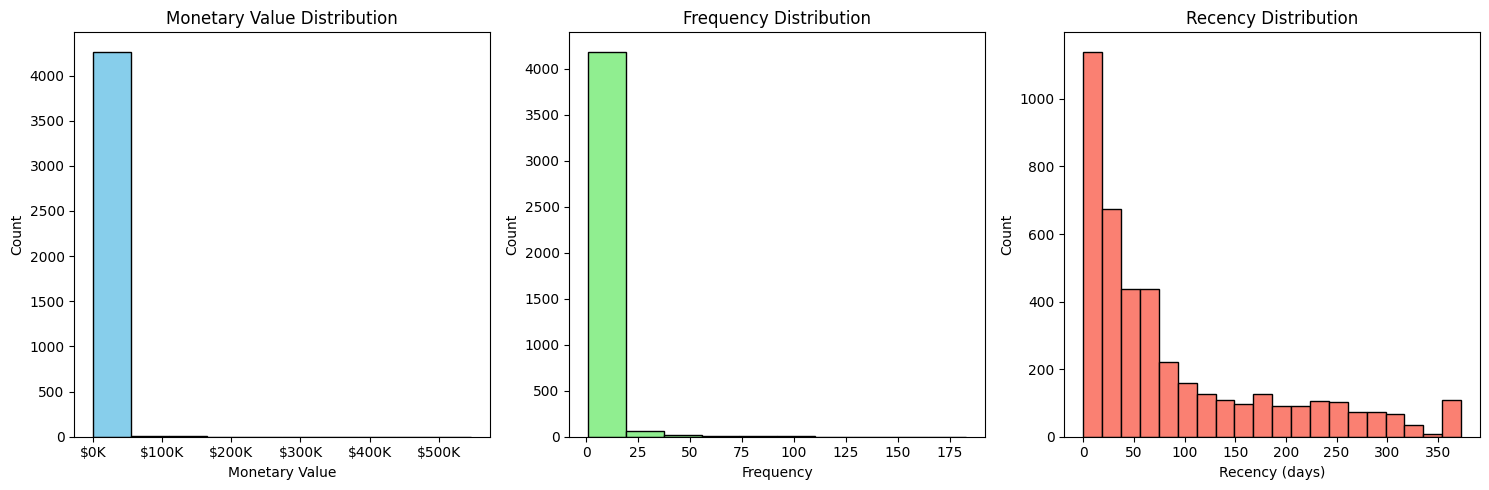

In [2197]:
# Create a currency formatter function

#def pounds_formatter(x, pos):
def dollars_formatter(x, pos):
    #return '£%1.0fK' % (x * 1e-3)  # Converts to thousands with £ symbol
    return '$%1.0fK' % (x * 1e-3)  # Converts to thousands with $ symbol


plt.figure(figsize=(15, 5))

# First plot - Monetary Value (with custom formatting)
ax1 = plt.subplot(1, 3, 1)
plt.hist(aggregated_df["MonetaryValue"], bins=10, color="skyblue", edgecolor="black")
plt.title("Monetary Value Distribution")
plt.xlabel("Monetary Value")
plt.ylabel("Count")
#ax1.xaxis.set_major_formatter(FuncFormatter(pounds_formatter))  # Apply only to this plot
ax1.xaxis.set_major_formatter(FuncFormatter(dollars_formatter))  # Apply only to this plot

# Second plot - Frequency (normal formatting)
plt.subplot(1, 3, 2)
plt.hist(aggregated_df["Frequency"], bins=10, color="lightgreen", edgecolor="black")
plt.title("Frequency Distribution")
plt.xlabel("Frequency")
plt.ylabel("Count")

# Third plot - Recency (normal formatting)
plt.subplot(1, 3, 3)
plt.hist(aggregated_df["Recency"], bins=20, color="salmon", edgecolor="black")
plt.title("Recency Distribution")
plt.xlabel("Recency (days)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


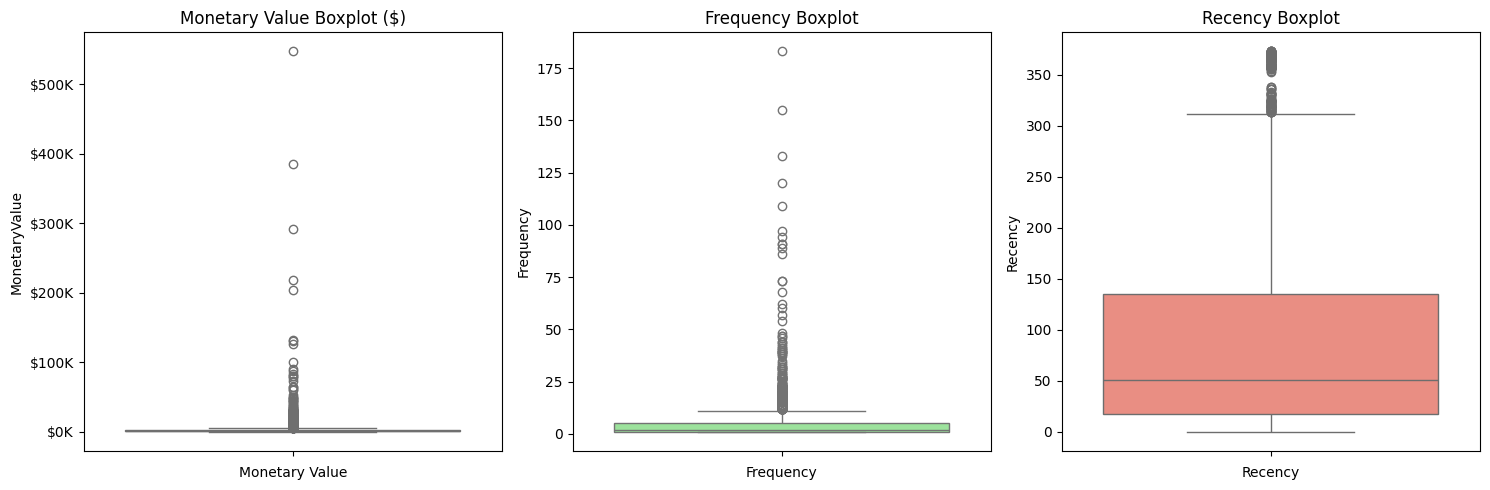

In [2198]:
# # Create the formatter function
def dollars_formatter(x, pos):
    return '$%1.0fK' % (x * 1e-3)  # Converts to thousands with $ symbol

plt.figure(figsize=(15, 5))

# First Boxplot - Monetary Value
ay1=plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df["MonetaryValue"], color="skyblue")
plt.title("Monetary Value Boxplot ($)")
plt.xlabel("Monetary Value")

ay1.yaxis.set_major_formatter(FuncFormatter(dollars_formatter))  # Apply only to this plot


# Second Boxplot - Frequency
plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df["Frequency"], color="lightgreen")
plt.title("Frequency Boxplot")
plt.xlabel("Frequency")


# Third Boxplot - Recency
plt.subplot(1, 3, 3)
sns.boxplot(aggregated_df["Recency"], color="salmon")
plt.title("Recency Boxplot")
plt.xlabel("Recency")

plt.tight_layout()
plt.show()

In [2203]:
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = aggregated_df[(aggregated_df["MonetaryValue"] > (M_Q3 + 1.5 * M_IQR)) | (aggregated_df["MonetaryValue"] < (M_Q1 - 1.5 * M_IQR))].copy()
monetary_outliers_df.describe()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,421.00,421.00,421.00,421,421.00
mean,"15,099.56","19,043.84",17.21,2010-11-09 08:53:35.201900288,29.63
min,"12,357.00","5,963.57",1.00,2009-12-10 00:00:00,0.00
25%,"13,615.00","7,172.74",8.00,2010-11-08 00:00:00,3.00
50%,"14,961.00","9,744.40",12.00,2010-11-26 00:00:00,13.00
75%,"16,700.00","15,672.94",18.00,2010-12-06 00:00:00,31.00
max,"18,260.00","547,094.44",183.00,2010-12-09 00:00:00,364.00
std,"1,731.02","40,416.78",19.77,NaN,51.46


In [2200]:
F_Q1 = aggregated_df["Frequency"].quantile(0.25)
F_Q3 = aggregated_df["Frequency"].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = aggregated_df[(aggregated_df["Frequency"] > (F_Q3 + 1.5 * F_IQR)) | (aggregated_df["Frequency"] < (F_Q1 - 1.5 * F_IQR))].copy()
frequency_outliers_df.describe()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,279.00,279.00,279.00,279,279.00
mean,"15,352.66","22,435.76",23.81,2010-11-22 21:50:58.064516096,16.09
min,"12,437.00","1,679.58",12.00,2010-05-12 00:00:00,0.00
25%,"13,800.00","6,704.66",13.00,2010-11-20 00:00:00,2.00
50%,"15,465.00","10,248.12",17.00,2010-12-02 00:00:00,7.00
75%,"16,828.50","18,056.38",23.00,2010-12-07 00:00:00,19.00
max,"18,260.00","547,094.44",183.00,2010-12-09 00:00:00,211.00
std,"1,748.43","48,997.36",21.93,NaN,26.59


In [2034]:
non_outliers_df = aggregated_df[(~aggregated_df.index.isin(monetary_outliers_df.index)) & (~aggregated_df.index.isin(frequency_outliers_df.index))]
non_outliers_df.describe()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,"3,811.00","3,811.00","3,811.00",3811,"3,811.00"
mean,"15,376.72","1,381.22",2.87,2010-09-02 21:46:37.061138944,97.09
min,"12,346.00",2.36,1.00,2009-12-01 00:00:00,0.00
25%,"13,912.50",432.45,1.00,2010-07-08 00:00:00,22.00
50%,"15,389.00",910.70,2.00,2010-10-12 00:00:00,58.00
75%,"16,855.00","1,975.11",4.00,2010-11-17 00:00:00,154.00
max,"18,287.00","5,953.82",11.00,2010-12-09 00:00:00,373.00
std,"1,692.90","1,274.97",2.25,NaN,98.08


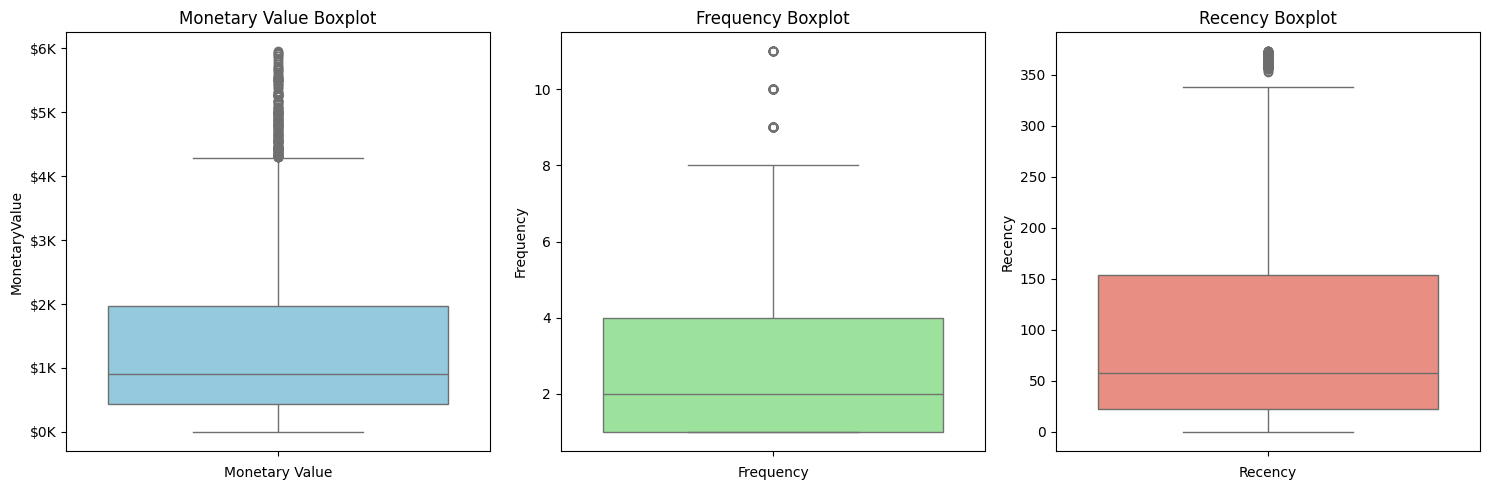

In [2035]:
# Create the formatter function
def dollars_formatter(x, pos):
    return '$%1.0fK' % (x * 1e-3)  # Converts to thousands with $ symbol

plt.figure(figsize=(15, 5))

# First Boxplot - Monetary Value
ay1=plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df["MonetaryValue"], color="skyblue")
plt.title("Monetary Value Boxplot")
plt.xlabel("Monetary Value")
ay1.yaxis.set_major_formatter(FuncFormatter(dollars_formatter))  # Apply only to this plot


# Second Boxplot - Frequency
plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df["Frequency"], color="lightgreen")
plt.title("Frequency Boxplot")
plt.xlabel("Frequency")


# Third Boxplot - Recency
plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df["Recency"], color="salmon")
plt.title("Recency Boxplot")
plt.xlabel("Recency")

plt.tight_layout()
plt.show()

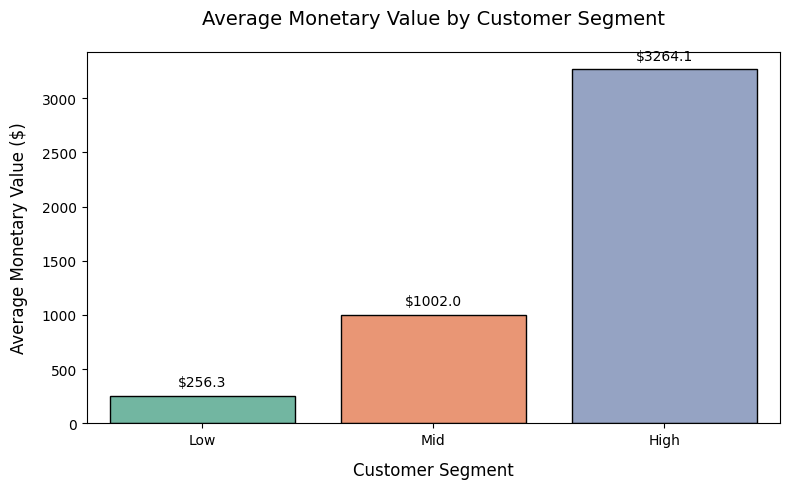

In [2036]:
# 1. Calculate segmentation thresholds
M_Q1 = non_outliers_df["MonetaryValue"].quantile(0.25)
M_Q3 = non_outliers_df["MonetaryValue"].quantile(0.75)

# 2. Create segments - fix SettingWithCopyWarning
non_outliers_df = non_outliers_df.copy()  # Create explicit copy
non_outliers_df.loc[:, 'ValueSegment'] = pd.cut(
    non_outliers_df['MonetaryValue'],
    bins=[-float('inf'), M_Q1, M_Q3, float('inf')],
    labels=['Low', 'Mid', 'High']
)

# 3. Calculate segment means - fix FutureWarning
segment_means = non_outliers_df.groupby('ValueSegment', observed=True)['MonetaryValue'].mean().reset_index()

# 4. Create column chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='ValueSegment',
    y='MonetaryValue',
    hue="ValueSegment",
    data=segment_means,
    order=['Low', 'Mid', 'High'],
    palette=['#66c2a5', '#fc8d62', '#8da0cb'],
    edgecolor='black'
)

# 5. Customize chart
plt.title('Average Monetary Value by Customer Segment', pad=20, fontsize=14)
plt.xlabel('Customer Segment', labelpad=10, fontsize=12)
plt.ylabel('Average Monetary Value ($)', labelpad=10, fontsize=12)

# 6. Add value labels
for p in ax.patches:
    ax.annotate(f'${p.get_height():.1f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

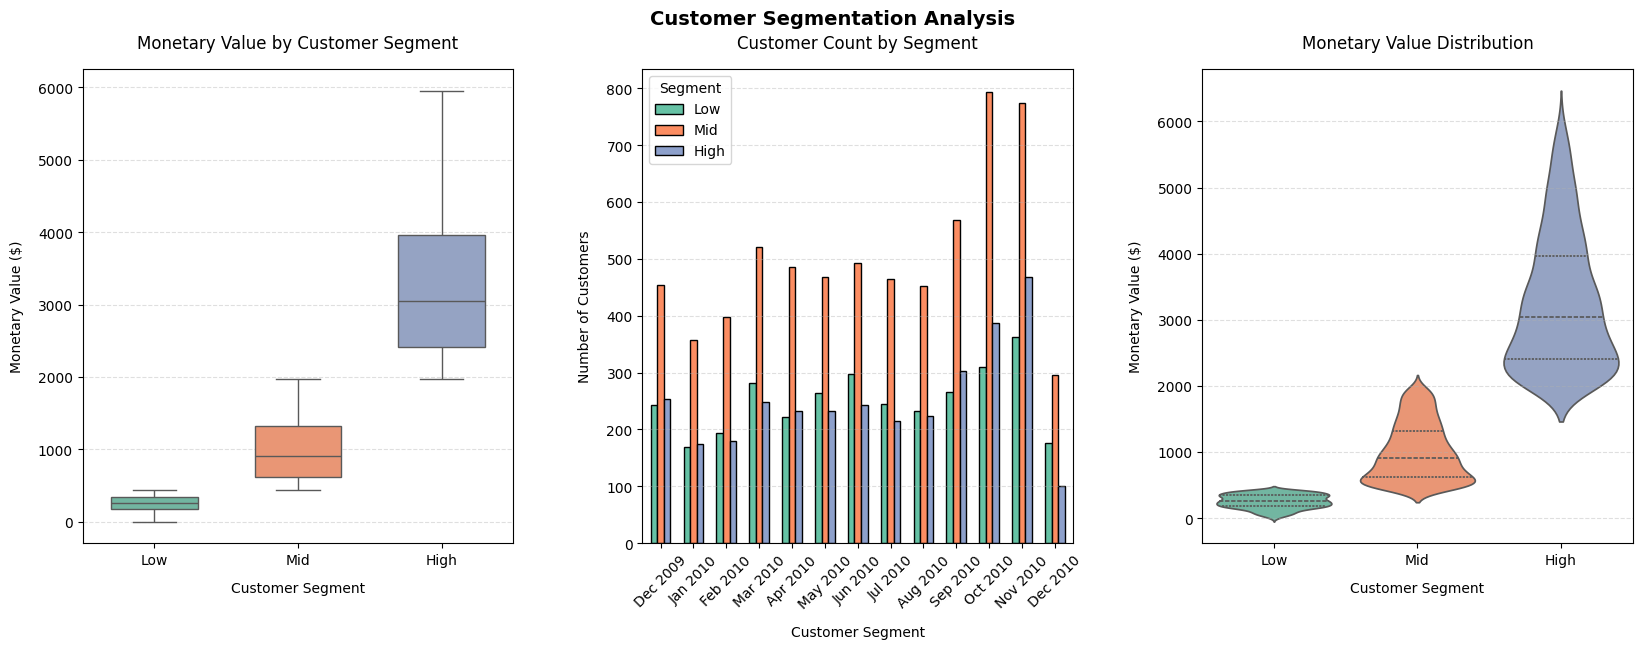

In [2037]:
# Set up the figure with subplots - don't use constrained_layout here
fig, axes = plt.subplots(1, 3, figsize=(20, 6), gridspec_kw={'wspace': 0.3})

# 1. Monetary Value Distribution by Segment (Boxplot)
sns.boxplot(
    x='ValueSegment',
    y='MonetaryValue',
    hue='ValueSegment',  # Added hue parameter
    data=non_outliers_df,
    order=['Low', 'Mid', 'High'],
    palette=['#66c2a5', '#fc8d62', '#8da0cb'],
    width=0.6,
    ax=axes[0]  # Specify which subplot to use
)
axes[0].set_title("Monetary Value by Customer Segment", pad=15, fontsize=12)
axes[0].set_xlabel("Customer Segment", labelpad=10, fontsize=10)
axes[0].set_ylabel("Monetary Value ($)", labelpad=10, fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.4)

# 2. Segment Size Distribution (Bar Plot)
segment_counts.plot(
    kind='bar',
    color=['#66c2a5', '#fc8d62', '#8da0cb'],
    edgecolor='black',
    width=0.6,
    ax=axes[1]  # Specify which subplot to use
)
axes[1].set_title("Customer Count by Segment", pad=15, fontsize=12)
axes[1].set_xlabel("Customer Segment", labelpad=10, fontsize=10)
axes[1].set_ylabel("Number of Customers", labelpad=10, fontsize=10)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.4)

# 3. Monetary Value Distribution (Violin Plot)
sns.violinplot(
    x='ValueSegment',
    y='MonetaryValue',
    hue='ValueSegment',
    data=non_outliers_df,
    order=['Low', 'Mid', 'High'],
    palette=['#66c2a5', '#fc8d62', '#8da0cb'],
    inner="quartile",
    ax=axes[2]  # Specify which subplot to use
)
axes[2].set_title("Monetary Value Distribution", pad=15, fontsize=12)
axes[2].set_xlabel("Customer Segment", labelpad=10, fontsize=10)
axes[2].set_ylabel("Monetary Value ($)", labelpad=10, fontsize=10)
axes[2].grid(axis='y', linestyle='--', alpha=0.4)

# Add super title
fig.suptitle("Customer Segmentation Analysis", y=1, fontsize=14, fontweight='bold')

# Adjust layout to ensure everything fits
#plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for the suptitle

plt.show()

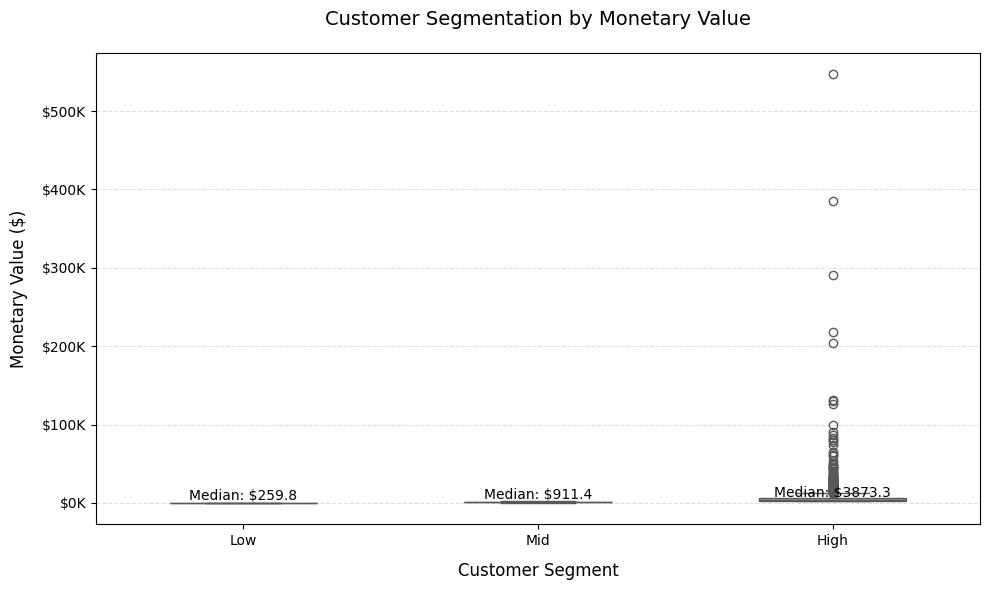

In [2038]:
#1. Create the ValueSegment if it doesn't exist
if 'ValueSegment' not in aggregated_df.columns:
    aggregated_df['ValueSegment'] = pd.cut(
        aggregated_df['MonetaryValue'],
        bins=[-float('inf'), M_Q1, M_Q3, float('inf')],
        labels=['Low', 'Mid', 'High']
    )

# 2. Create the dollars formatter
def dollars_formatter(x, pos):
    return '$%1.0fK' % (x * 1e-3)

# 3. Set up the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x='ValueSegment',
    y='MonetaryValue',
    hue='ValueSegment',
    data=aggregated_df,
    order=['Low', 'Mid', 'High'],
    palette=['#66c2a5', '#fc8d62', '#8da0cb'],
    legend=False,
    width=0.5
)

# 4. Customize the plot
plt.title('Customer Segmentation by Monetary Value', pad=20, fontsize=14)
plt.xlabel('Customer Segment', labelpad=10, fontsize=12)
plt.ylabel('Monetary Value ($)', labelpad=10, fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(dollars_formatter))

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.4)

# 5. Add annotations for Q1 and Q3 values
for i, segment in enumerate(['Low', 'Mid', 'High']):
    median_val = aggregated_df[aggregated_df['ValueSegment'] == segment]['MonetaryValue'].median()
    ax.text(i, median_val*1.1, f'Median: ${median_val:.1f}', 
            ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

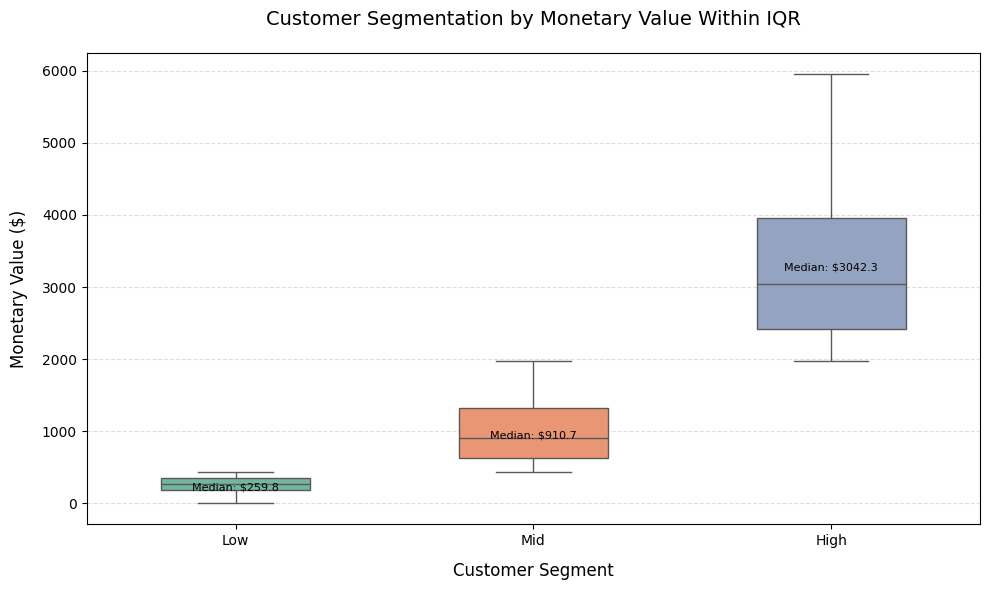

In [2039]:
#1. Create the ValueSegment if it doesn't exist
if 'ValueSegment' not in aggregated_df.columns:
    non_outliers_df['ValueSegment'] = pd.cut(
        non_outliers_df['MonetaryValue'],
        bins=[-float('inf'), M_Q1, M_Q3, float('inf')],
        labels=['Low', 'Mid', 'High']
    )

# 2. Create the dollars formatter
#def dollars_formatter(x, pos):
 #   return '$%1.0fK' % (x * 1e-3)

# 3. Set up the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x='ValueSegment',
    y='MonetaryValue',
    hue='ValueSegment',
    data=non_outliers_df,
    order=['Low', 'Mid', 'High'],
    palette=['#66c2a5', '#fc8d62', '#8da0cb'],
    legend=False,
    width=0.5
)

# 4. Customize the plot
plt.title('Customer Segmentation by Monetary Value Within IQR', pad=20, fontsize=14)
plt.xlabel('Customer Segment', labelpad=10, fontsize=12)
plt.ylabel('Monetary Value ($)', labelpad=10, fontsize=12)
#ax.yaxis.set_major_formatter(FuncFormatter(dollars_formatter))

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.4)

# 5. Add annotations for Q1 and Q3 values
for i, segment in enumerate(['Low', 'Mid', 'High']):
    median_val = non_outliers_df[non_outliers_df['ValueSegment'] == segment]['MonetaryValue'].median()
    ax.text(i, median_val*1.1, f'Median: ${median_val:.1f}', 
            ha='center', va='top', fontsize=8, color='black')

plt.tight_layout()
plt.show()

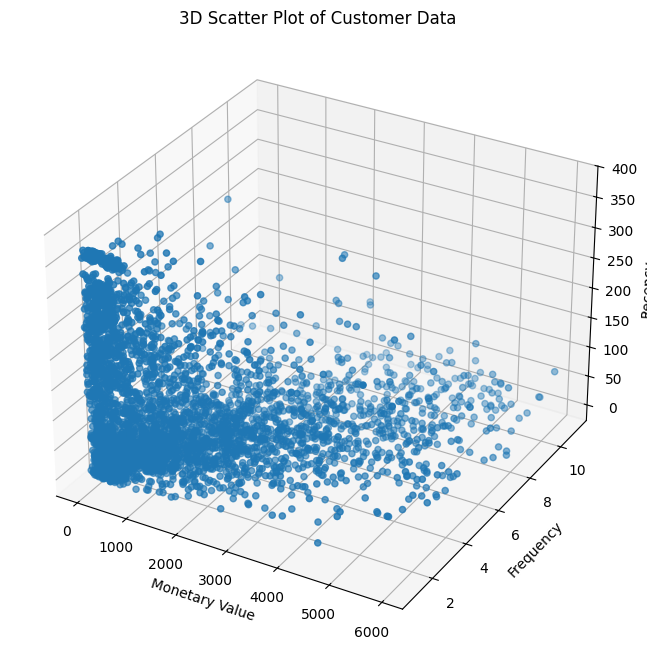

In [2040]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df["MonetaryValue"], non_outliers_df["Frequency"], non_outliers_df["Recency"])

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

ax.set_title("3D Scatter Plot of Customer Data")

plt.show()

#### Standard Scaling Formula

Standard scalling transforms data to have a mean of 0 and a standard deviation of 1, making different variables comparable regardless of their original scales.

$$Z = \frac{X - \mu}{\sigma}$$

Where:
- $Z$ = standardized value (z-score)
- $X$ = original value
- $\mu$ = mean of the population
- $\sigma$ = standard deviation of the population



In [2043]:
scaller = StandardScaler()

scaled_data = scaller.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency"]])
scaled_data

array([[-0.88306469, -0.38550565,  0.68226244],
       [ 0.55065027, -0.38550565, -0.96967082],
       [-0.8091786 , -0.83043661, -0.24567538],
       ...,
       [-0.61947043, -0.83043661,  2.01808501],
       [ 0.46484074, -0.38550565,  0.14181514],
       [ 1.63624007,  0.50435627, -0.81671404]], shape=(3811, 3))

In [2044]:
scaled_data_df  = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=["MonetaryValue", "Frequency", "Recency"])
scaled_data_df

,MonetaryValue,Frequency,Recency
0,-0.88,-0.39,0.68
1,0.55,-0.39,-0.97
2,-0.81,-0.83,-0.25
3,1.64,-0.39,-0.56
4,-0.71,-0.83,-0.89
...,...,...,...
4280,-0.31,1.39,-0.82
4281,-0.57,-0.83,-0.32
4282,-0.62,-0.83,2.02
4283,0.46,-0.39,0.14


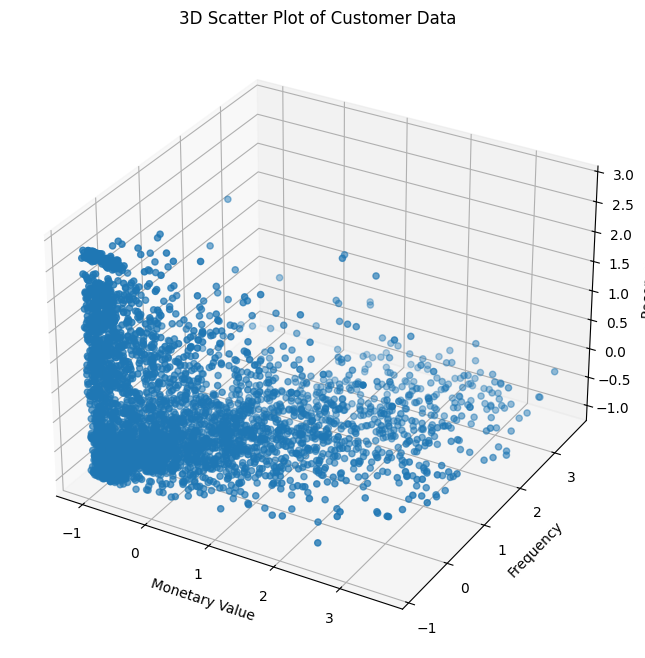

In [2045]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(scaled_data_df["MonetaryValue"], scaled_data_df["Frequency"], scaled_data_df["Recency"])

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

ax.set_title("3D Scatter Plot of Customer Data")

plt.show()

### KMeans Clustering

![clustering example](../data/clustering_example.png)

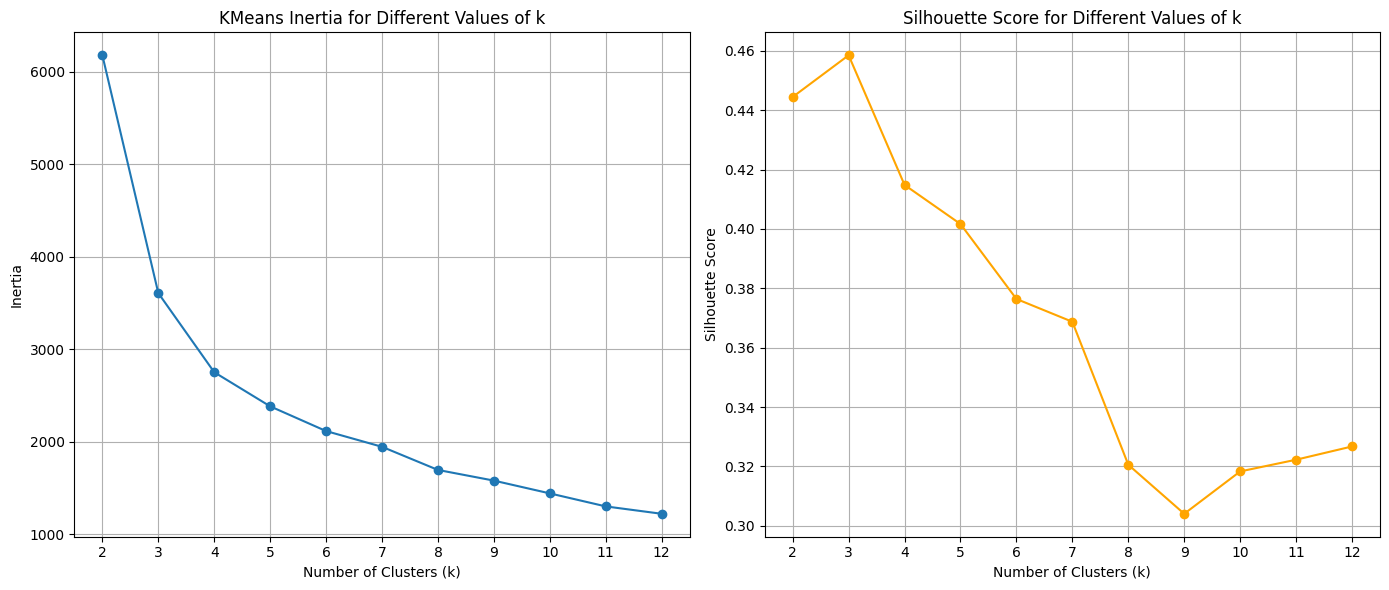

In [2046]:
max_k = 12

inertia = []
silhouette_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)

    cluster_labels = kmeans.fit_predict(scaled_data_df)

    sil_score = silhouette_score(scaled_data_df, cluster_labels)

    silhouette_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title("KMeans Inertia for Different Values of k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Score for Different Values of k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()




### Silhouette Score

The silhouette score for a single data point i is calculated as:

$$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$

Where:
- s(i)$ is the silhoutte score for a single sample i
- $a(i)$ is the average distance between point i and all other points in the same cluster
- $b(i)$ is the minimum average distance between point i and all points in the nearest cluster to which i does not belong.

The silhoutte score ranges between [-1, 1], a higher value indicates more distinct values.




In [2052]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(scaled_data_df)
cluster_labels

array([1, 0, 2, ..., 1, 0, 0], shape=(3811,), dtype=int32)

In [2053]:
non_outliers_df["Cluster"] = cluster_labels
non_outliers_df

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency,ValueSegment,Cluster
0,12346,255.49,2,2010-06-28,164,Low,1
1,12347,"2,083.19",2,2010-12-07,2,High,0
2,12348,349.68,1,2010-09-27,73,Low,2
3,12349,"3,466.20",2,2010-10-28,42,High,0
4,12351,470.15,1,2010-11-29,10,Mid,2
...,...,...,...,...,...,...,...
4280,18283,991.35,6,2010-11-22,17,Mid,0
4281,18284,649.50,1,2010-10-04,66,Mid,2
4282,18285,591.52,1,2010-02-17,295,Mid,1
4283,18286,"1,973.80",2,2010-08-20,111,Mid,0


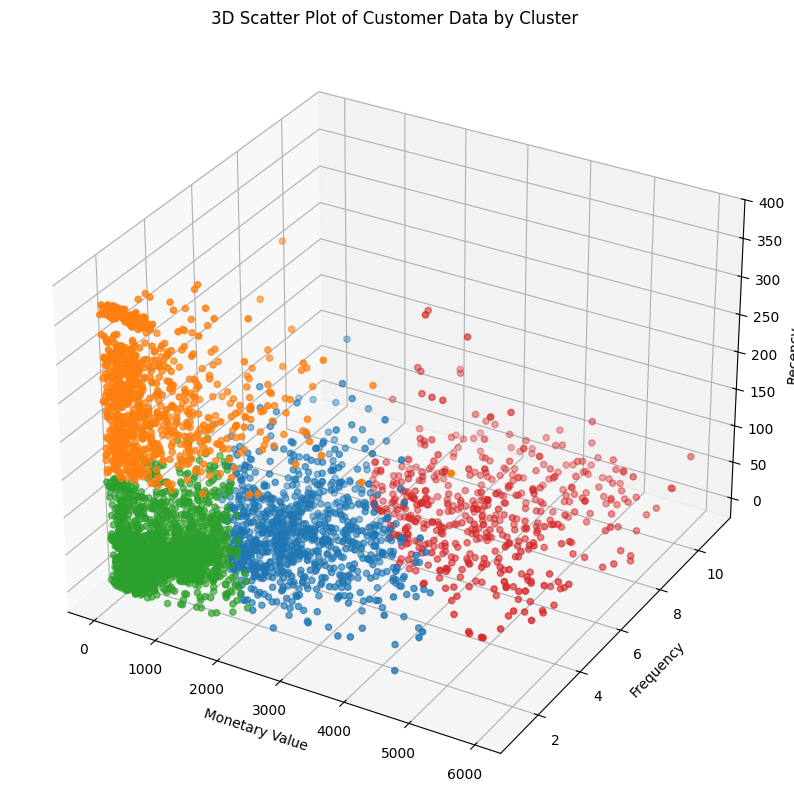

In [2054]:
cluster_colors = {0: '#1f77b4', #Blue
                  1: '#ff7f0e', #Orange
                  2: '#2ca02c', #Green
                  3: '#d62728'} #Red

colors = non_outliers_df["Cluster"].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'],
                     non_outliers_df['Frequency'],
                     non_outliers_df['Recency'],
                     c=colors,
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

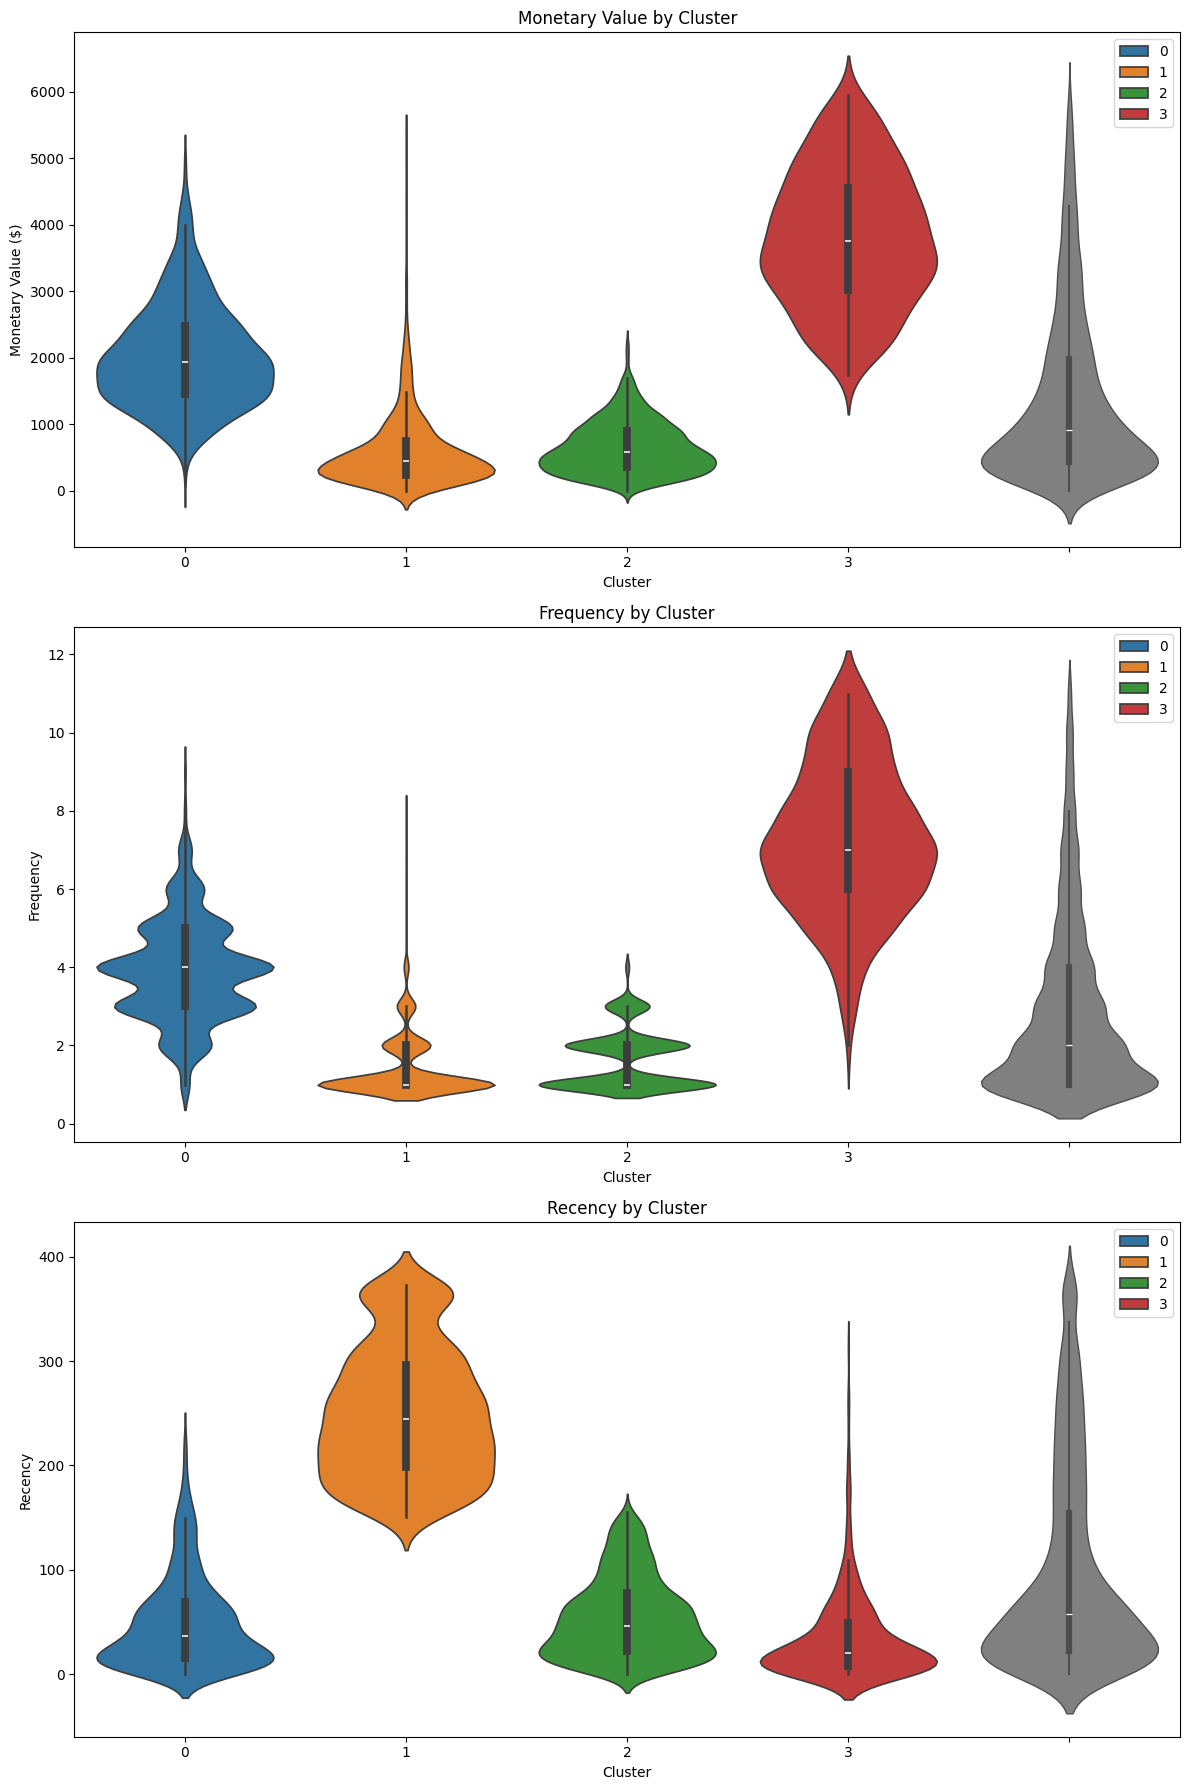

In [2055]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['MonetaryValue'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value ($)')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

#### Recommendations:

#### 1. Cluster 0 (Blue): "Retain"
Explanation: This group consists of valuable customers who buy frequently, though their most recent purchase might not have been very recent. The main goal is to keep them loyal and maintain their current level of spending.

* Recommended Strategy: Introduce loyalty schemes, send personalized promotions, and maintain regular communication to keep them engaged.

#### Cluster 1 (Orange): "Re-Engage"
Explanation: These are customers with lower value who purchase occasionally and haven’t bought anything in a while. The goal is to reignite their interest and encourage them to start buying again.

* Recommended Strategy: Use targeted ads, offer special discounts, or send reminder emails to motivate them to return.

#### Cluster 2 (Green): "Nurture"
Explanation: This segment includes the least active and lowest-spending customers, but they have made recent purchases. They might be new or need more attention to increase their interest and spending.

* Recommended Strategy: Focus on relationship-building, excellent service, and small incentives to gradually increase their involvement.

#### Cluster 3 (Red): "Reward"
Explanation: These are your top customers—frequent, high-value buyers who are still actively purchasing. They show strong loyalty, and recognizing their contribution is essential to keep them happy.

* Recommended Strategy: Offer premium loyalty rewards, exclusive deals, and personalized recognition to sustain their enthusiasm and commitment.



Cluster Summary:

* Cluster 0 (Blue): "Retain"

* Cluster 1 (Orange): "Re-Engage"

* Cluster 2 (Green): "Nurture"

* Cluster 3 (Red): "Reward"

In [2056]:
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices]

monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

outlier_clusters_df

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
9,12357,"17,967.28",1,2010-11-16,23,-1
25,12380,"7,352.70",4,2010-08-31,100,-1
42,12409,"18,691.32",4,2010-10-15,55,-1
48,12415,"30,204.24",4,2010-11-29,10,-1
61,12431,"6,399.09",11,2010-12-01,8,-1
...,...,...,...,...,...,...
4235,18223,"11,856.85",12,2010-11-17,22,-3
4236,18225,"11,682.55",15,2010-12-09,0,-3
4237,18226,"10,328.14",15,2010-11-26,13,-3
4241,18231,"7,354.59",23,2010-10-29,41,-3


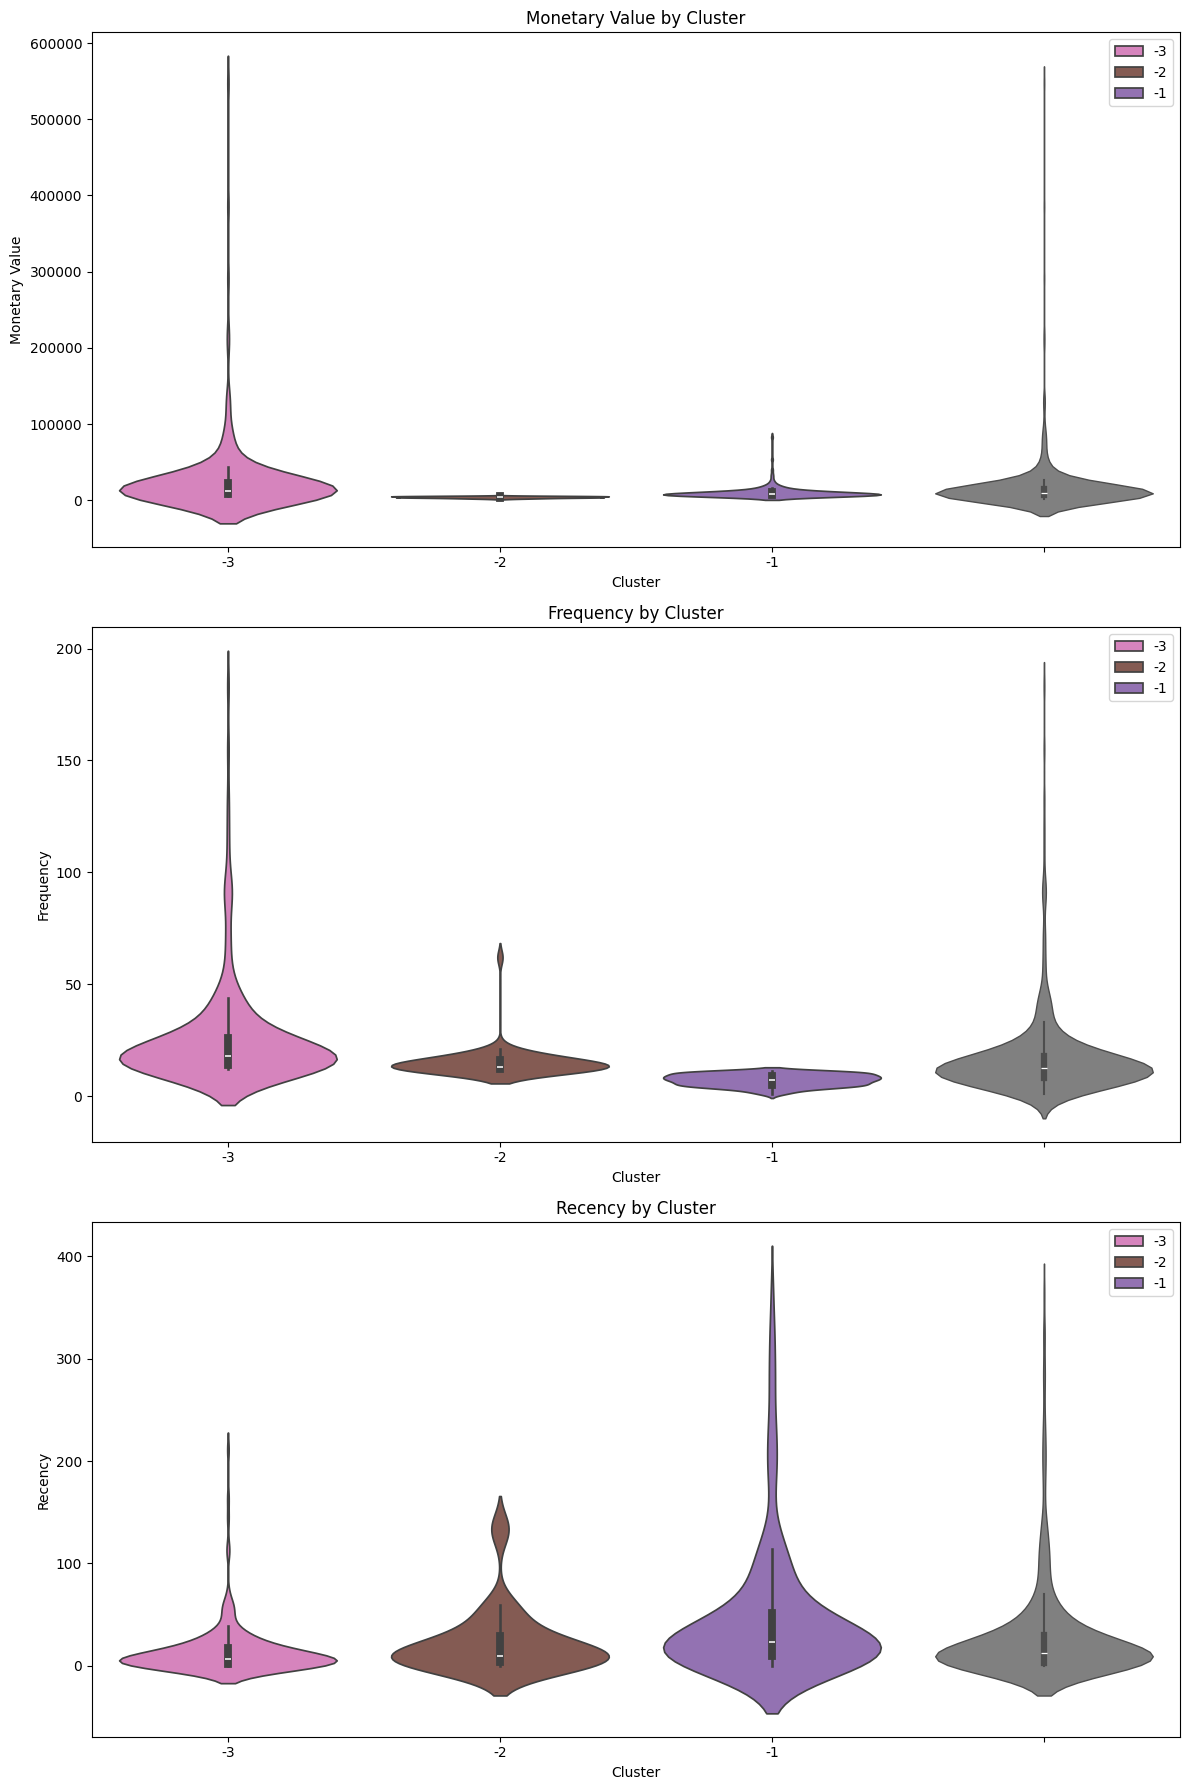

In [2057]:
cluster_colors = {-1: '#9467bd', #Blue
                  -2: '#8c564b', #Brown
                  -3: '#e377c2'} #Pink

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['MonetaryValue'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

* Cluster 1 (Monetary Outliers) PAMPER: 

Profile: These customers are high spenders but not necessarily frequent buyers. Their purchases/transactions are large but infrequent.

Recommended strategy: Focus on maintaining their loyalty with personalized offers, experiences or luxury services that cater to their high spending capacity.

* Cluster 2 (Frequency Outliers) UPSELL: 

Profile: These customers are frequent buyers who spend less per purchase. They are consistently active and engaged, but might benefit from upselling opportunities.

Recommended strategy:  Introduce loyalty incentives or product bundles deals to encourage higher spending per visit. Given their frequent engagement focus on capitalizing on their steady buying behavior.

* Cluster 3 (Monetary & Frequency Outliers) DELIGHT:

Profile: This group includes your most valuable customers, who not only spend a lot but also buy frequently. They are top-tier customers that contribute significantly to the company's revenue and who require special attention. 

Recommended strategy: Develop VIP programs and perks, and/or exclusive offers to maintain their loyalty and encourage continued engagement.

In [2090]:
cluster_labels = {
    0: "RETAIN",
    1: "RE-ENGAGE",
    2: "NURTURE",
    3: "REWARD",
    -1: "PAMPER",
    -2: "UPSELL",
    -3: "DELIGHT"
}

In [2091]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])
full_clustering_df

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency,ValueSegment,Cluster
0,12346,255.49,2,2010-06-28,164,Low,1
1,12347,"2,083.19",2,2010-12-07,2,High,0
2,12348,349.68,1,2010-09-27,73,Low,2
3,12349,"3,466.20",2,2010-10-28,42,High,0
4,12351,470.15,1,2010-11-29,10,Mid,2
...,...,...,...,...,...,...,...
4235,18223,"11,856.85",12,2010-11-17,22,NaN,-3
4236,18225,"11,682.55",15,2010-12-09,0,NaN,-3
4237,18226,"10,328.14",15,2010-11-26,13,NaN,-3
4241,18231,"7,354.59",23,2010-10-29,41,NaN,-3


In [2092]:
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)
full_clustering_df

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency,ValueSegment,Cluster,ClusterLabel
0,12346,255.49,2,2010-06-28,164,Low,1,RE-ENGAGE
1,12347,"2,083.19",2,2010-12-07,2,High,0,RETAIN
2,12348,349.68,1,2010-09-27,73,Low,2,NURTURE
3,12349,"3,466.20",2,2010-10-28,42,High,0,RETAIN
4,12351,470.15,1,2010-11-29,10,Mid,2,NURTURE
...,...,...,...,...,...,...,...,...
4235,18223,"11,856.85",12,2010-11-17,22,NaN,-3,DELIGHT
4236,18225,"11,682.55",15,2010-12-09,0,NaN,-3,DELIGHT
4237,18226,"10,328.14",15,2010-11-26,13,NaN,-3,DELIGHT
4241,18231,"7,354.59",23,2010-10-29,41,NaN,-3,DELIGHT


## Visualization

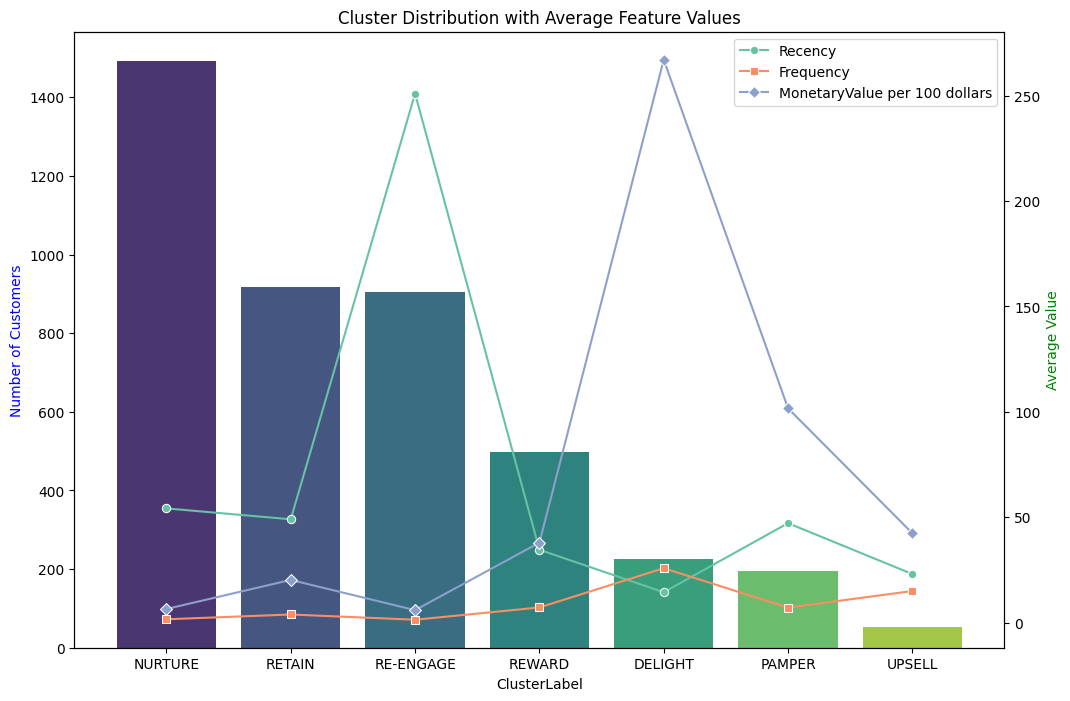

In [2109]:
# cluster_counts = full_clustering_df["ClusterLabel"].value_counts()
# full_clustering_df["MonetaryValue per 100 dollars"] = full_clustering_df["MonetaryValue"] / 100.00
# feature_means = full_clustering_df.groupby("ClusterLabel")[["Recency", "Frequency", "MonetaryValue per 100 dollars"]].mean()

# fig,ax1 = plt.subplots(figsize=(12, 8))

# sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
# ax1.set_ylabel("Number of Customers", color='b')
# ax1.set_title("Cluster Distribution with Average Feature Values")

# ax2 = ax1.twinx()

# sns.lineplot(data=feature_means, ax=ax2, palette='Set2', markers='o')
# ax2.set_ylabel("Average Value", color='g')

# plt.show()

cluster_counts = full_clustering_df["ClusterLabel"].value_counts()
full_clustering_df["MonetaryValue per 100 dollars"] = full_clustering_df["MonetaryValue"] / 100.00
feature_means = full_clustering_df.groupby("ClusterLabel")[["Recency", "Frequency", "MonetaryValue per 100 dollars"]].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot for cluster counts
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel("Number of Customers", color='b')
ax1.set_title("Cluster Distribution with Average Feature Values")

ax2 = ax1.twinx()

# Line plot for feature means - specify markers for each line
sns.lineplot(data=feature_means, ax=ax2, palette='Set2', markers=['o', 's', 'D'], dashes=False)
ax2.set_ylabel("Average Value", color='g')

plt.show()


In [2093]:
non_outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3811 entries, 0 to 4284
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       3811 non-null   Int64         
 1   MonetaryValue    3811 non-null   float64       
 2   Frequency        3811 non-null   int64         
 3   LastInvoiceDate  3811 non-null   datetime64[ns]
 4   Recency          3811 non-null   int64         
 5   ValueSegment     3811 non-null   category      
 6   Cluster          3811 non-null   int32         
dtypes: Int64(1), category(1), datetime64[ns](1), float64(1), int32(1), int64(2)
memory usage: 330.1 KB


In [2094]:
outlier_clusters_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 474 entries, 9 to 4262
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       474 non-null    Int64         
 1   MonetaryValue    474 non-null    float64       
 2   Frequency        474 non-null    int64         
 3   LastInvoiceDate  474 non-null    datetime64[ns]
 4   Recency          474 non-null    int64         
 5   Cluster          474 non-null    int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 26.4 KB


In [2110]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406309 entries, 0 to 406308
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Invoice            406309 non-null  object        
 1   StockCode          406309 non-null  object        
 2   Description        406309 non-null  object        
 3   Quantity           406309 non-null  int64         
 4   InvoiceDate        316296 non-null  datetime64[ns]
 5   CustomerID         406309 non-null  Int64         
 6   PriceGBP           406309 non-null  float64       
 7   ExchangeRate       406309 non-null  float64       
 8   PriceUSD           406309 non-null  float64       
 9   SalesLineTotalUSD  406309 non-null  float64       
 10  SalesLineTotalGBP  406309 non-null  float64       
 11  Country            406309 non-null  object        
 12  YearMonth          316296 non-null  period[M]     
dtypes: Int64(1), datetime64[ns](1), float64(5), 

In [2111]:
merged_df.isna().sum()

Invoice                  0
StockCode                0
Description              0
Quantity                 0
InvoiceDate          90013
CustomerID               0
PriceGBP                 0
ExchangeRate             0
PriceUSD                 0
SalesLineTotalUSD        0
SalesLineTotalGBP        0
Country                  0
YearMonth            90013
dtype: int64

In [2096]:
# Convert InvoiceDate to datetime and extract year-month
# cleaned_df['InvoiceDate'] = pd.to_datetime(cleaned_df['InvoiceDate'])
# cleaned_df['YearMonth'] = cleaned_df['InvoiceDate'].dt.to_period('M')

# Convert InvoiceDate to datetime and extract year-month
merged_df['InvoiceDate'] = pd.to_datetime(cleaned_df['InvoiceDate'])
merged_df['YearMonth'] = merged_df['InvoiceDate'].dt.to_period('M')

# Calculate RFM per customer per month
monthly_rfm = merged_df.groupby(['CustomerID', 'YearMonth']).agg({
    'InvoiceDate': lambda x: (merged_df['InvoiceDate'].max() - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'SalesLineTotalUSD': 'sum'  # Monetary
}).reset_index().rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'SalesLineTotalUSD': 'Monetary'
})

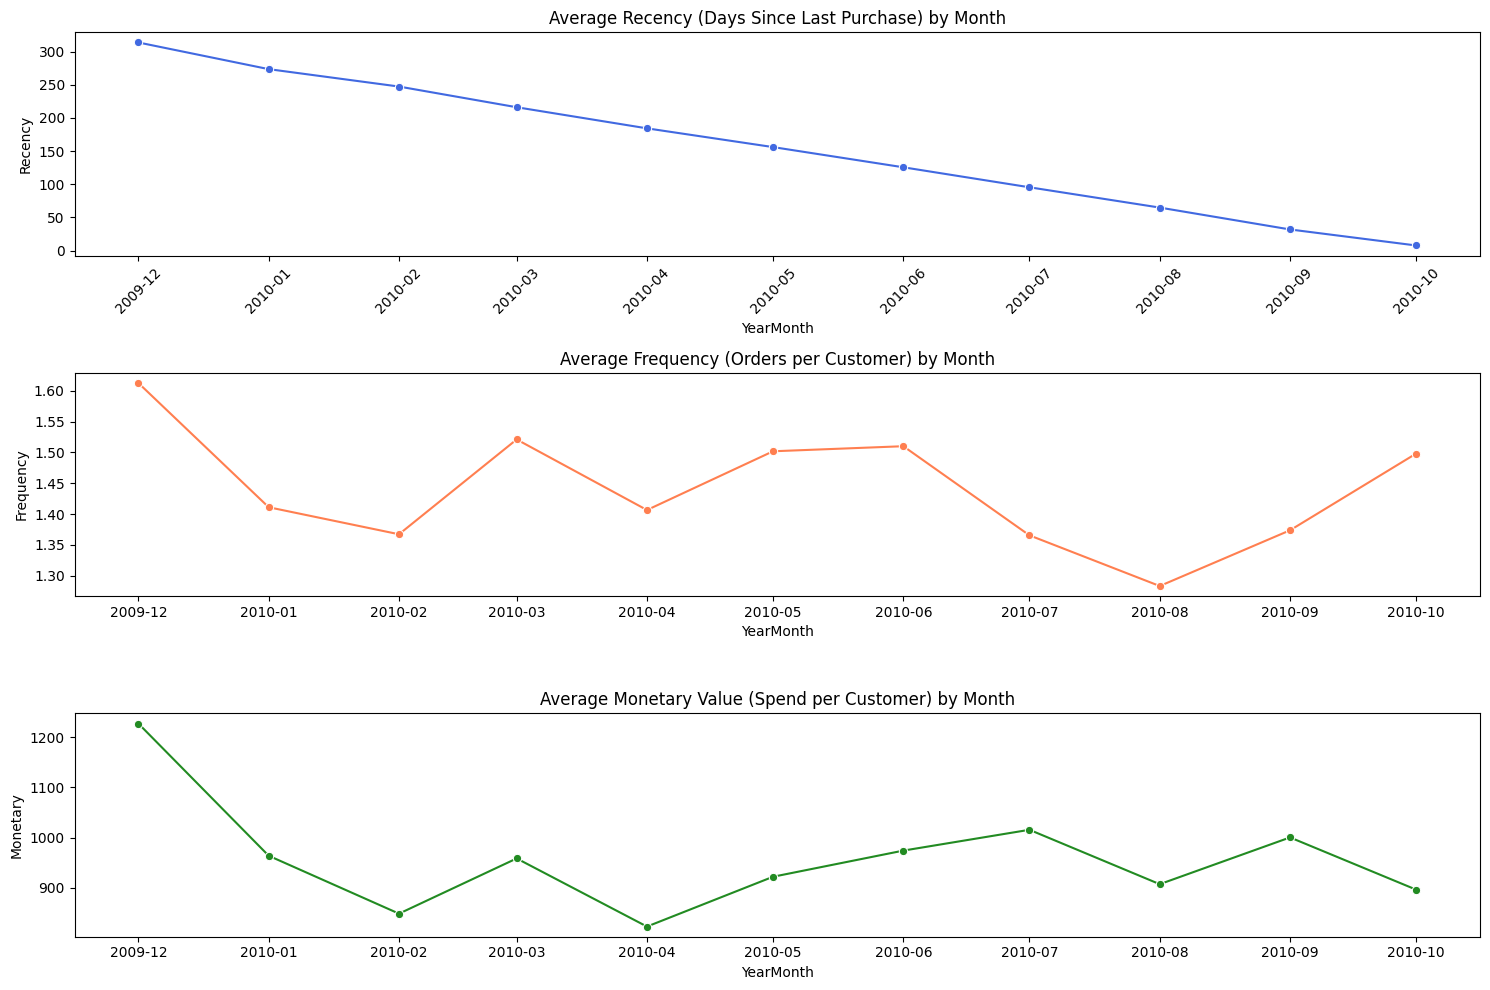

In [2097]:
# 2. Visualize Trends Over Time
# A. Monthly Average RFM Trends

plt.figure(figsize=(15, 10))

# Convert Period to datetime for plotting
monthly_rfm['YearMonth'] = monthly_rfm['YearMonth'].dt.to_timestamp()

# Plot Recency
plt.subplot(3, 1, 1)
sns.lineplot(
    data=monthly_rfm.groupby('YearMonth')['Recency'].mean().reset_index(),
    x='YearMonth', 
    y='Recency',
    marker='o', 
    color='royalblue'
)
plt.title('Average Recency (Days Since Last Purchase) by Month')
plt.xticks(rotation=45)

# Plot Frequency
plt.subplot(3, 1, 2)
sns.lineplot(
    data=monthly_rfm.groupby('YearMonth')['Frequency'].mean().reset_index(),
    x='YearMonth', 
    y='Frequency',
    marker='o', 
    color='coral'
)
plt.title('Average Frequency (Orders per Customer) by Month')

# Plot Monetary
plt.subplot(3, 1, 3)
sns.lineplot(
    data=monthly_rfm.groupby('YearMonth')['Monetary'].mean().reset_index(),
    x='YearMonth', 
    y='Monetary',
    marker='o', 
    color='forestgreen'
)
plt.title('Average Monetary Value (Spend per Customer) by Month')

plt.tight_layout()
plt.show()

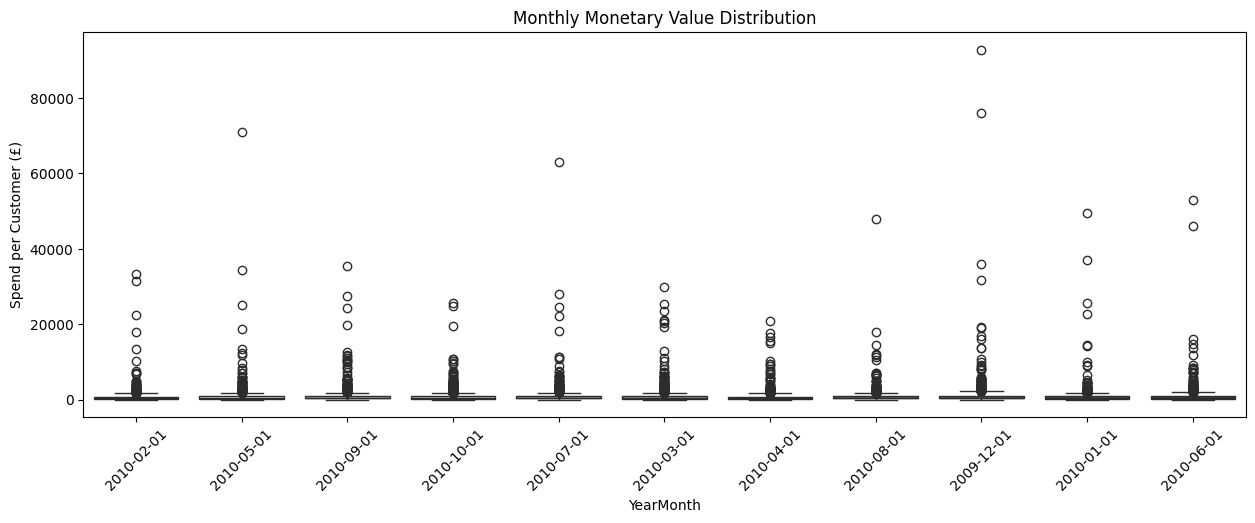

In [2098]:
# B. Monthly RFM Distribution (Boxplot)
plt.figure(figsize=(15, 5))

# Monetary Value Distribution
sns.boxplot(
    data=monthly_rfm,
    x='YearMonth', 
    y='Monetary',
    hue='YearMonth',  # Add hue parameter
    palette='Blues',
    legend=False  # Hide the legend since it would be redundant
)

plt.title('Monthly Monetary Value Distribution')
plt.xticks(rotation=45)
plt.ylabel('Spend per Customer (£)')
plt.show()

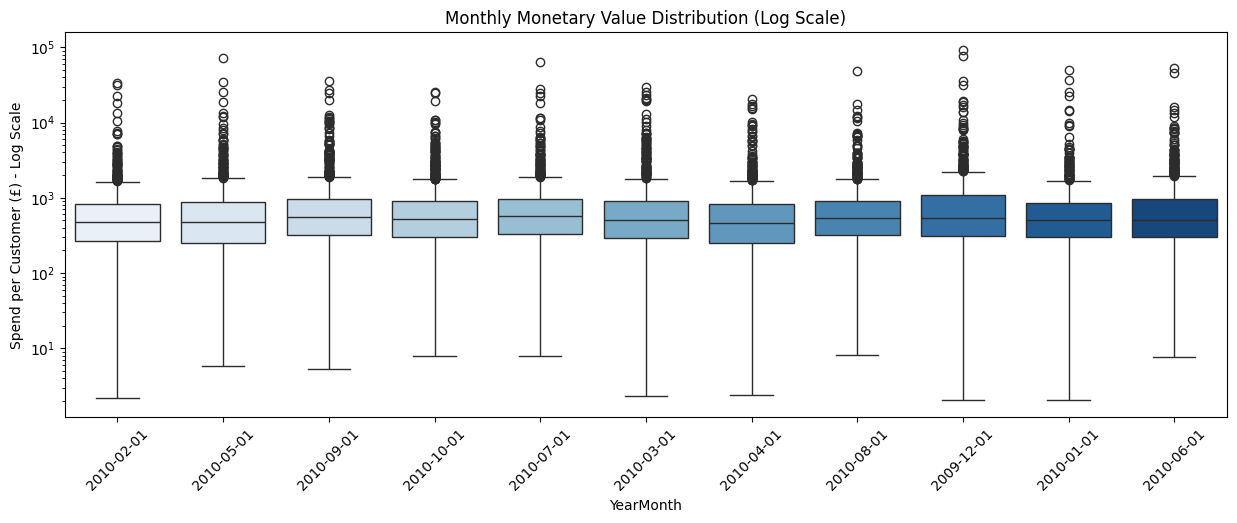

In [2099]:
plt.figure(figsize=(15, 5))

sns.boxplot(
    data=monthly_rfm,
    x='YearMonth', 
    y='Monetary',
    hue='YearMonth',
    palette='Blues',
    legend=False
)

plt.title('Monthly Monetary Value Distribution (Log Scale)')
plt.xticks(rotation=45)
plt.ylabel('Spend per Customer (£) - Log Scale')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()

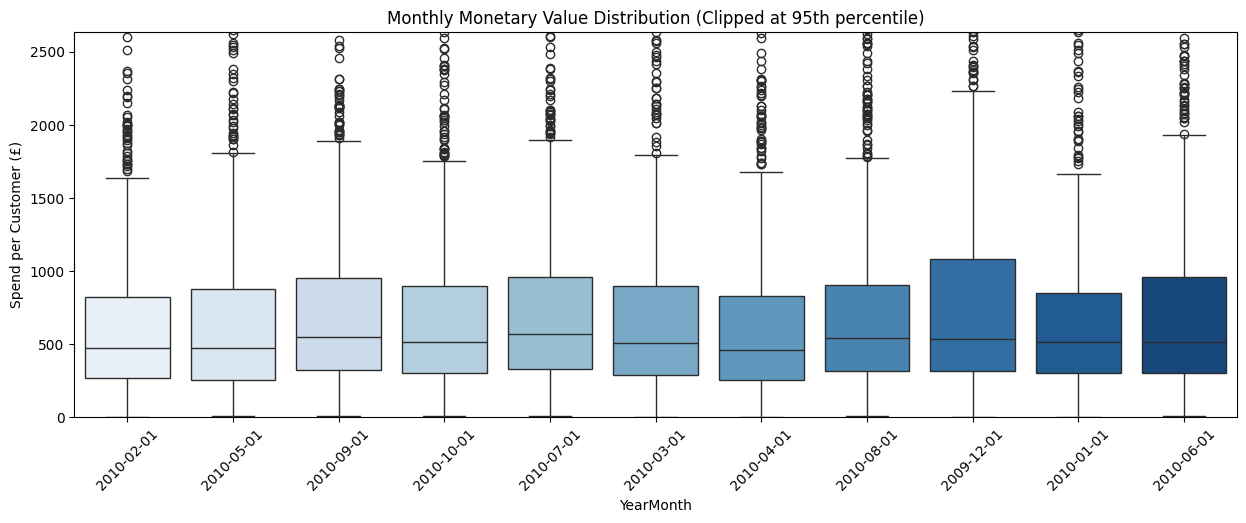

In [2100]:
plt.figure(figsize=(15, 5))

sns.boxplot(
    data=monthly_rfm,
    x='YearMonth', 
    y='Monetary',
    hue='YearMonth',
    palette='Blues',
    legend=False
)

# Calculate a reasonable upper limit (e.g., 95th or 99th percentile)
upper_limit = monthly_rfm['Monetary'].quantile(0.95)  # Adjust percentage as needed
plt.ylim(0, upper_limit)

plt.title('Monthly Monetary Value Distribution (Clipped at 95th percentile)')
plt.xticks(rotation=45)
plt.ylabel('Spend per Customer (£)')
plt.show()

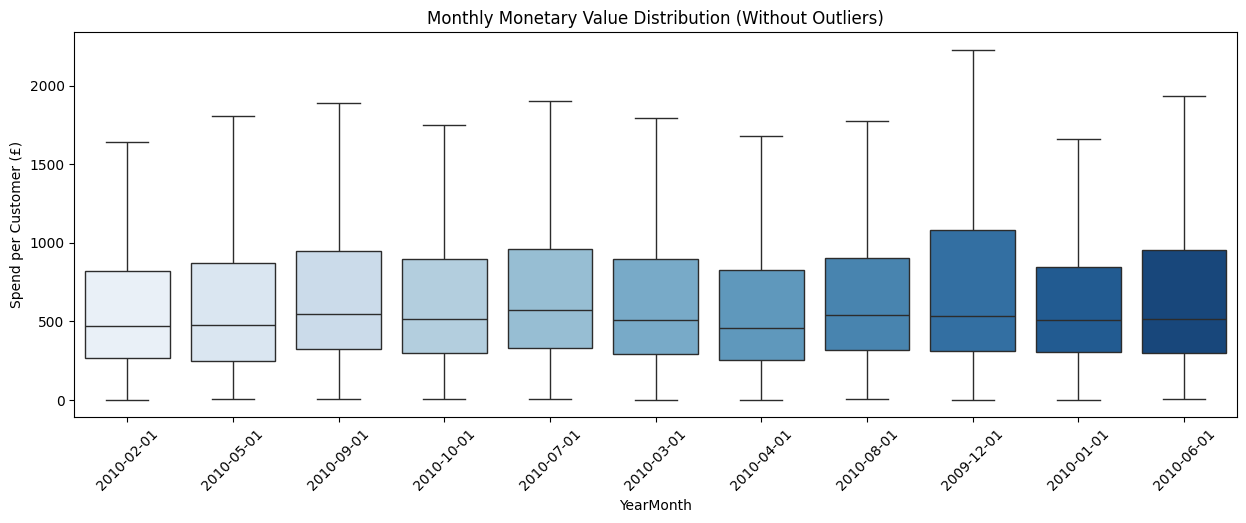

In [2101]:
plt.figure(figsize=(15, 5))

sns.boxplot(
    data=monthly_rfm,
    x='YearMonth', 
    y='Monetary',
    hue='YearMonth',
    palette='Blues',
    legend=False,
    showfliers=False  # This hides the outlier points
)

plt.title('Monthly Monetary Value Distribution (Without Outliers)')
plt.xticks(rotation=45)
plt.ylabel('Spend per Customer (£)')
plt.show()

In [2102]:
# Convert scores to numeric first
monthly_rfm[['R_Score', 'F_Score', 'M_Score']] = monthly_rfm[['R_Score', 'F_Score', 'M_Score']].astype(float)

# Now calculate mean and create heatmap
heatmap_data = monthly_rfm.groupby('YearMonth')[['R_Score', 'F_Score', 'M_Score']].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data.T,
    annot=True,
    fmt='.1f',
    cmap='YlGnBu',
    linewidths=0.5,
    vmin=1,
    vmax=5
)
plt.title('Average RFM Scores by Month', pad=20)
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel('RFM Dimension')
plt.show()

KeyError: "None of [Index(['R_Score', 'F_Score', 'M_Score'], dtype='object')] are in the [columns]"

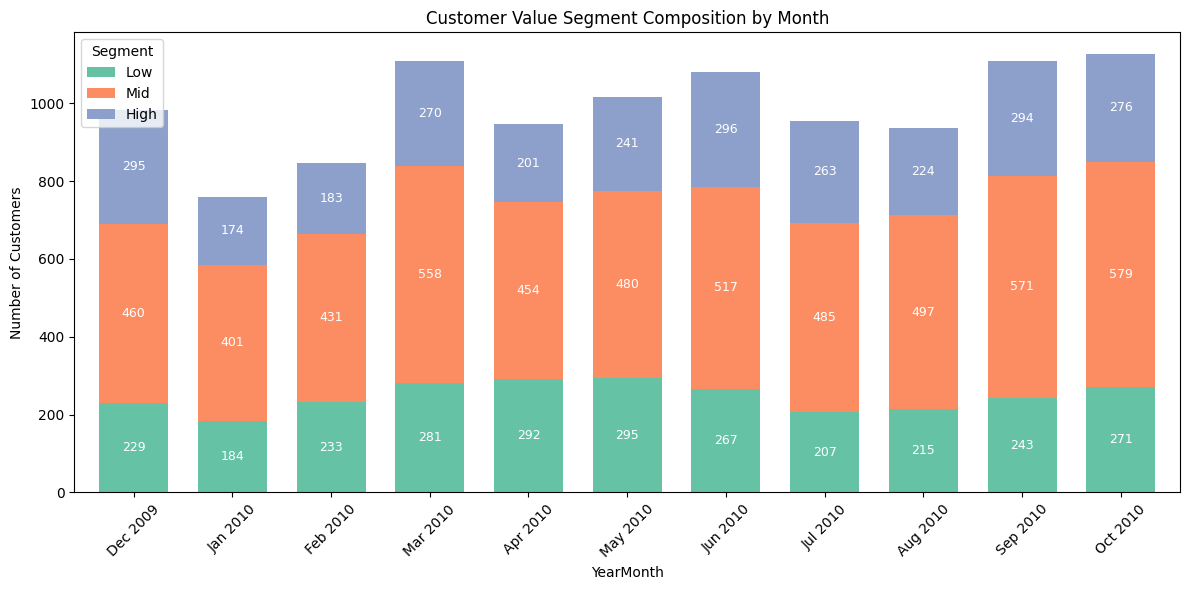

In [ ]:
# Assign segments (e.g., using RFM quartiles)
monthly_rfm['Segment'] = pd.cut(
    monthly_rfm['Monetary'],
    bins=[0, monthly_rfm['Monetary'].quantile(0.25), 
          monthly_rfm['Monetary'].quantile(0.75), float('inf')],
    labels=['Low', 'Mid', 'High']
)

# Plot segment distribution
segment_counts = monthly_rfm.groupby(['YearMonth', 'Segment'], observed=True).size().unstack()

# Convert index to Month-Year format - for object dtype
# First convert to datetime, then format
segment_counts.index = pd.to_datetime(segment_counts.index).strftime('%b %Y')

# Store the axes reference in ax
ax = segment_counts.plot(
    kind='bar', 
    stacked=True,
    figsize=(12, 6),
    color=['#66c2a5', '#fc8d62', '#8da0cb'],
    width=0.7
)

# Add value labels
for i, (index, row) in enumerate(segment_counts.iterrows()):
    y_offset = 0
    for segment in ['Low', 'Mid', 'High']:
        if segment in row:
            value = row[segment]
            if value > 0:
                ax.text(i, y_offset + value/2, f'{int(value)}',
                        ha='center', va='center',
                        color='white', fontsize=9)
            y_offset += value

plt.title('Customer Value Segment Composition by Month')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Segment', loc='upper left')
plt.tight_layout()  # Added to ensure labels don't get cut off
plt.show()

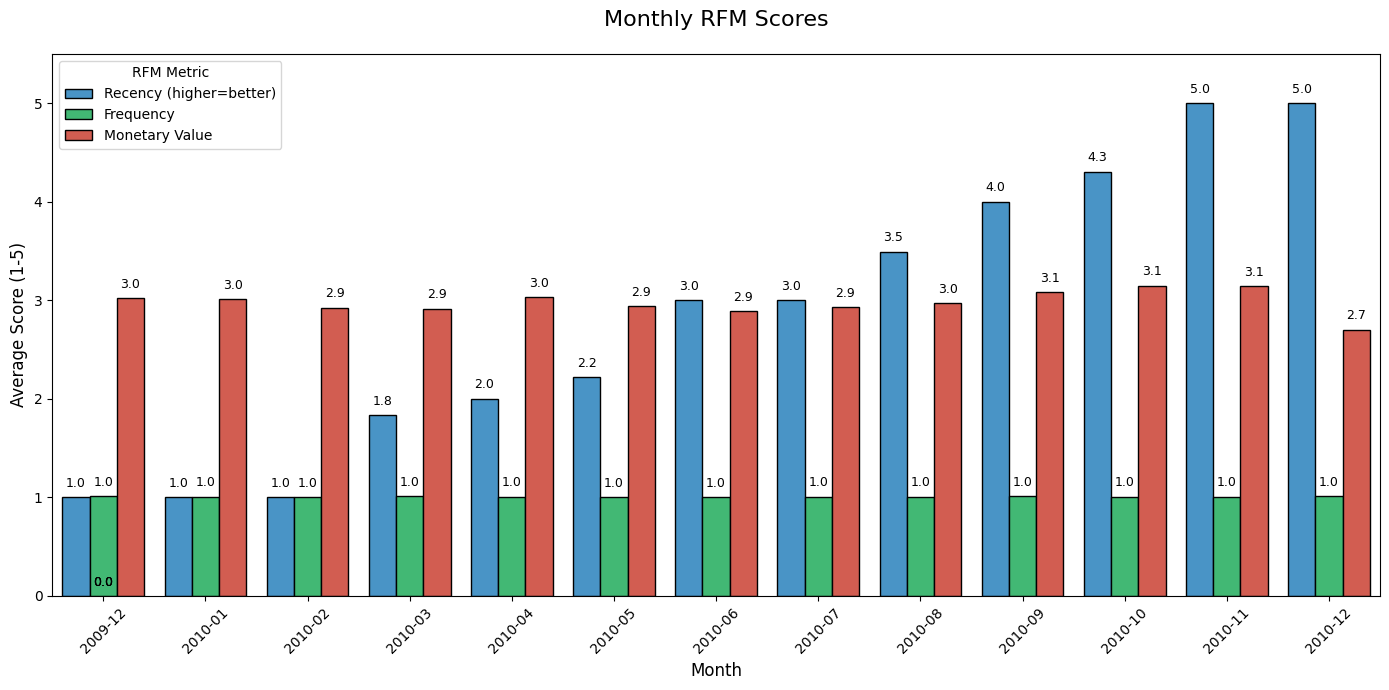

In [ ]:

plt.figure(figsize=(14, 7))

# Create the plot
ax = sns.barplot(data=rfm_melted,
                x='YearMonth',
                y='Score',
                hue='Metric',
                palette={'R_Score': '#3498db', 
                        'F_Score': '#2ecc71', 
                        'M_Score': '#e74c3c'},
                edgecolor='black')

# Customize the plot
plt.title('Monthly RFM Scores', fontsize=16, pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Score (1-5)', fontsize=12)
plt.ylim(0, 5.5)

# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=9)

# Improve legend - Get handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Define your custom labels in the correct order (matching R_Score, F_Score, M_Score)
custom_labels = ['Recency (higher=better)', 'Frequency', 'Monetary Value']

# Update the legend with correct colors and labels
plt.legend(handles=handles, 
           labels=custom_labels,
           title='RFM Metric',
           loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `R_Score` for `y`. An entry with this name does not appear in `data`.

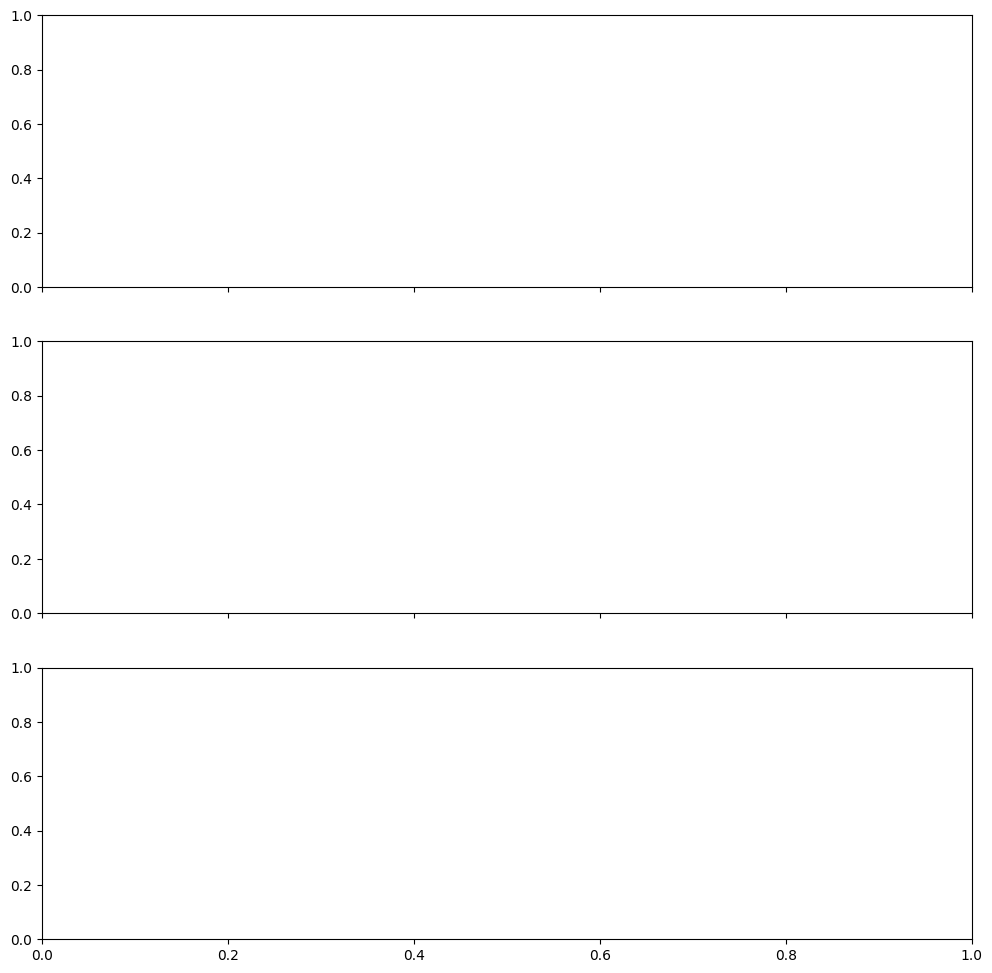

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

metrics = ['R_Score', 'F_Score', 'M_Score']
colors = ['#3498db', '#2ecc71', '#e74c3c']
titles = ['Recency (Higher = More Recent)', 'Frequency', 'Monetary Value']

for ax, metric, color, title in zip(axes, metrics, colors, titles):
    sns.barplot(data=monthly_rfm,
               x='YearMonth',
               y=metric,
               color=color,
               ax=ax,
               edgecolor='black')
    
    ax.set_title(title, fontsize=13)
    ax.set_ylabel('Score (1-5)')
    ax.set_ylim(0, 5.5)
    
    # Add value labels
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', 
                   xytext=(0, 5), 
                   textcoords='offset points',
                   fontsize=9)

plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

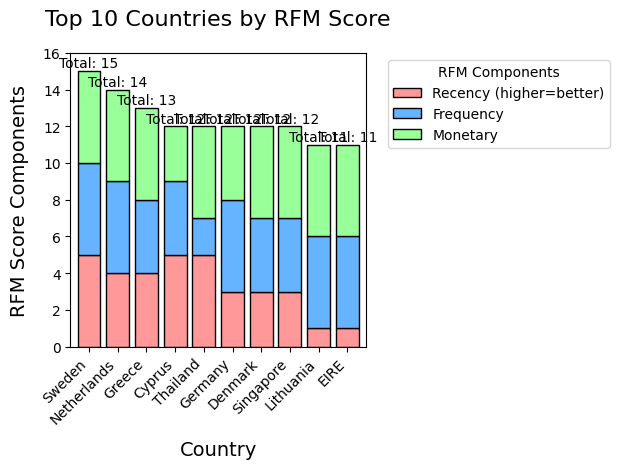

In [ ]:
# 1. Prepare the data (using your existing country_rfm DataFrame)
top_countries = country_rfm.head(10).set_index('Country')

# 2. Create the plot
plt.figure(figsize=(14, 8))
ax = top_countries[['R_Score', 'F_Score', 'M_Score']].plot(
    kind='bar',
    stacked=True,
    color=['#ff9999','#66b3ff','#99ff99'],
    width=0.8,
    edgecolor='black'
)

# 3. Add value labels
for i, (country, row) in enumerate(top_countries.iterrows()):
    total_height = row['R_Score'] + row['F_Score'] + row['M_Score']
    ax.text(i, total_height + 0.2, 
            f'Total: {row["RFM_Score"]:.0f}',
            ha='center',
            fontsize=10)

# 4. Customize the plot
plt.title('Top 10 Countries by RFM Score', fontsize=16, pad=20)
plt.xlabel('Country', fontsize=14, labelpad=10)
plt.ylabel('RFM Score Components', fontsize=14, labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.legend(
    title='RFM Components',
    labels=['Recency (higher=better)', 'Frequency', 'Monetary'],
    bbox_to_anchor=(1.05, 1)
)
plt.ylim(0, 16)  # Adjust based on your score range
plt.tight_layout()
plt.show()

<Figure size 1400x1400 with 0 Axes>

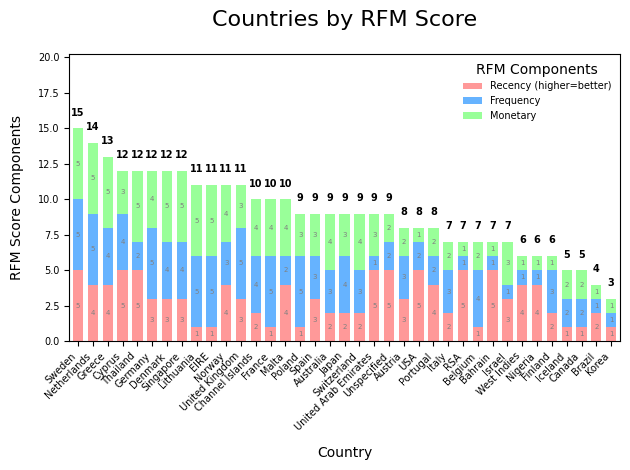

In [ ]:
# Prepare the data
countries_rfm = country_rfm.set_index('Country')

# Create the plot
plt.figure(figsize=(14, 14))
ax = countries_rfm[['R_Score', 'F_Score', 'M_Score']].plot(
    kind='bar',
    stacked=True,
    color=['#ff9999', '#66b3ff', '#99ff99'],
    width=0.7
)

# Calculate positions for non-overlapping labels
y_offset = countries_rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1).max() * 0.05

# Add value labels with proper spacing
for i, (country, row) in enumerate(countries_rfm.iterrows()):
    total_height = row['R_Score'] + row['F_Score'] + row['M_Score']
    ax.text(
        i, 
        total_height + y_offset,  # Dynamic spacing
        f'{row["RFM_Score"]:.0f}',
        ha='center',
        va='bottom',
        fontsize=7,
        fontweight='bold'
    )
# Add value labels
for i, (country, row) in enumerate(countries_rfm.iterrows()):
    y_offset = 0
    for segment in ['R_Score', 'F_Score', 'M_Score']:
        if segment in row:
            value = row[segment]
            if value > 0:
                ax.text(i, y_offset + value/2, f'{int(value)}',
                        ha='center', va='center',
                        color='grey', fontsize=5)
            y_offset += value

# Customize the plot
plt.title('Countries by RFM Score', fontsize=16, pad=20)
plt.xlabel('Country', fontsize=10, labelpad=10)
plt.ylabel('RFM Score Components', fontsize=10, labelpad=10)
plt.xticks(rotation=45, fontsize= 7, ha='right')
plt.yticks(fontsize= 7)

# Position legend in upper right without overlapping
plt.legend(
    title='RFM Components',
    fontsize=7,
    labels=['Recency (higher=better)', 'Frequency', 'Monetary'],
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Precise positioning
    frameon=False  # Cleaner look
)

# Adjust ylim to accommodate labels
max_score = countries_rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1).max()
plt.ylim(0, max_score * 1.35)  # 15% headroom for labels

plt.tight_layout()
plt.show()

<Figure size 1400x1000 with 0 Axes>

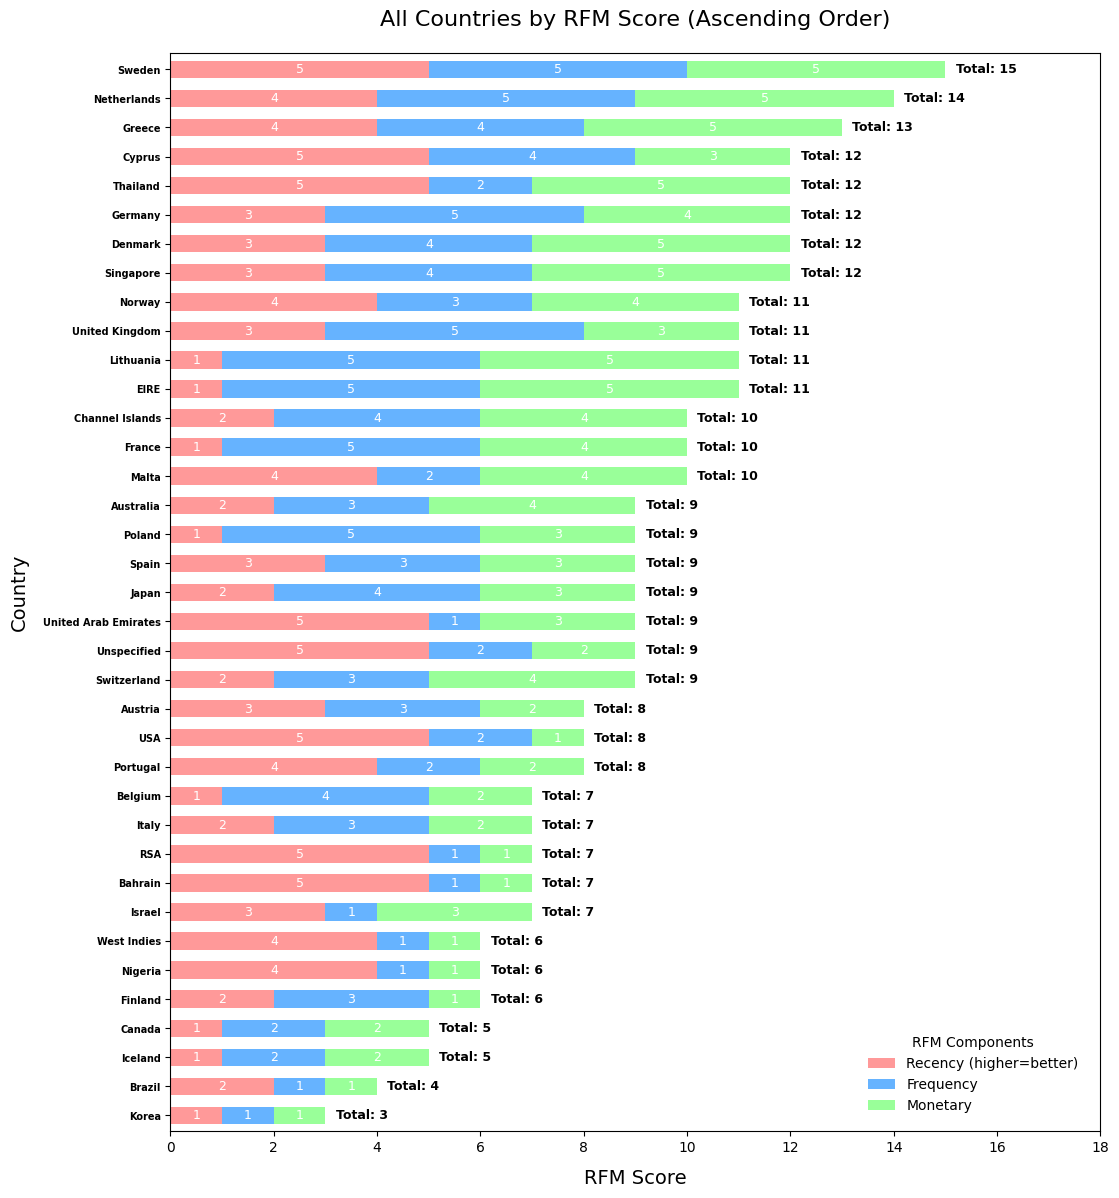

In [ ]:
# Sort countries by RFM_Score in ascending order
country_rfm_sorted = country_rfm.sort_values('RFM_Score', ascending=True)

# Create the plot
plt.figure(figsize=(14, 10))  # Increased height for more countries
ax = country_rfm_sorted[['R_Score', 'F_Score', 'M_Score']].plot(
    kind='barh',  # Horizontal bars
    stacked=True,
    color=['#ff9999', '#66b3ff', '#99ff99'],
    width=0.6,
    edgecolor=None,
    figsize=(12, 14)
)

# Set the y-tick labels to show country names
ax.set_yticklabels(country_rfm_sorted['Country'], fontsize=14, fontweight='bold')

# Add value labels with proper spacing
for i, (country, row) in enumerate(country_rfm_sorted.iterrows()):
    total_width = row['R_Score'] + row['F_Score'] + row['M_Score']
    ax.text(
        total_width + 0.2,  # Position text just outside the bar
        i, 
        f'Total: {row["RFM_Score"]:.0f}',
        va='center',
        fontsize=9,
        fontweight='bold'
    )

# Add value labels - Modified for horizontal bars
for y_pos, (country, row) in enumerate(country_rfm_sorted.iterrows()):
    x_offset = 0  # Start from left edge for horizontal bars
    for segment in ['R_Score', 'F_Score', 'M_Score']:
        if segment in row:
            value = row[segment]
            if value > 0:
                ax.text(
                    x_offset + value/2,  # X position (middle of segment)
                    y_pos,               # Y position (country level)
                    f'{int(value)}',
                    ha='center', 
                    va='center',
                    color='white', 
                    fontsize=9
                )
            x_offset += value  # Move right for next segment

# Customize the plot
plt.title('All Countries by RFM Score (Ascending Order)', fontsize=16, pad=20)
plt.xlabel('RFM Score', fontsize=14, labelpad=10)
plt.ylabel('Country', fontsize=14, labelpad=10)
plt.yticks(fontsize=7)

# Position legend in upper right
plt.legend(
    title='RFM Components',
    labels=['Recency (higher=better)', 'Frequency', 'Monetary'],
    bbox_to_anchor=(.99, 0.10),
    frameon=False
)

# Adjust xlim to accommodate labels
max_score = country_rfm_sorted[['R_Score', 'F_Score', 'M_Score']].sum(axis=1).max()
plt.xlim(0, max_score * 1.2)  # 20% headroom for labels

#plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

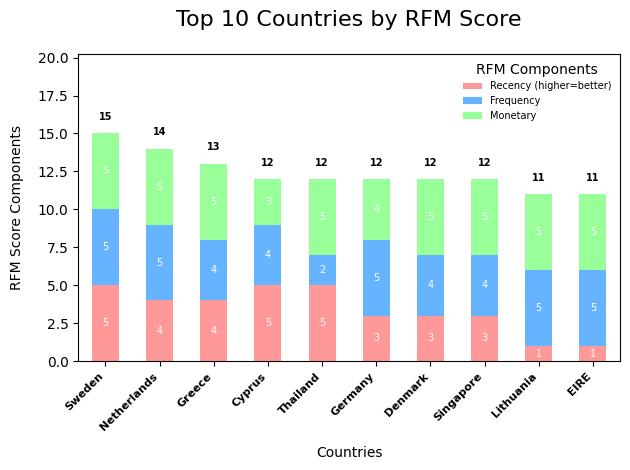

In [ ]:
# Prepare the data
top_countries = country_rfm.head(10).set_index('Country')
# Create the plot
plt.figure(figsize=(14, 7))
ax = top_countries[['R_Score', 'F_Score', 'M_Score']].plot(
    kind='bar',
    stacked=True,
    color=['#ff9999', '#66b3ff', '#99ff99'],
    width=0.5
)

# Calculate positions for non-overlapping labels
y_offset = top_countries[['R_Score', 'F_Score', 'M_Score']].sum(axis=1).max() * 0.05

# Add value labels with proper spacing
for i, (country, row) in enumerate(top_countries.iterrows()):
    total_height = row['R_Score'] + row['F_Score'] + row['M_Score']
    ax.text(
        i, 
        total_height + y_offset,  # Dynamic spacing
        f'{row["RFM_Score"]:.0f}',
        ha='center',
        va='bottom',
        fontsize=7,
        fontweight='bold'
    )

# Add value labels
for i, (country, row) in enumerate(top_countries.iterrows()):
    y_offset = 0
    for segment in ['R_Score', 'F_Score', 'M_Score']:
        if segment in row:
            value = row[segment]
            if value > 0:
                ax.text(i, y_offset + value/2, f'{int(value)}',
                        ha='center', va='center',
                        color='white', fontsize=7)
            y_offset += value

# Customize the plot
plt.title('Top 10 Countries by RFM Score', fontsize=16, pad=20)
plt.xlabel('Countries', fontsize=10, labelpad=10)
plt.ylabel('RFM Score Components', fontsize=10, labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=8, fontweight='bold')

# Position legend in upper right without overlapping
plt.legend(
    title='RFM Components',
    fontsize=7,
    labels=['Recency (higher=better)', 'Frequency', 'Monetary'],
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Precise positioning
    frameon=False  # Cleaner look
)


# Adjust ylim to accommodate labels
max_score = top_countries[['R_Score', 'F_Score', 'M_Score']].sum(axis=1).max()
plt.ylim(0, max_score * 1.35)  # 15% headroom for labels

plt.tight_layout()
plt.show()

In [ ]:
outlier_clusters_df.info()
cleaned_df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 474 entries, 9 to 4262
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CustomerID       474 non-null    Int64         
 1   MonetaryValue    474 non-null    float64       
 2   Frequency        474 non-null    int64         
 3   LastInvoiceDate  474 non-null    datetime64[ns]
 4   Recency          474 non-null    int64         
 5   Cluster          474 non-null    int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 26.4 KB
<class 'pandas.core.frame.DataFrame'>
Index: 406309 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406309 non-null  object        
 1   StockCode    406309 non-null  object        
 2   Description  406309 non-null  object        
 3   Quantity     406309 non-null  int64 

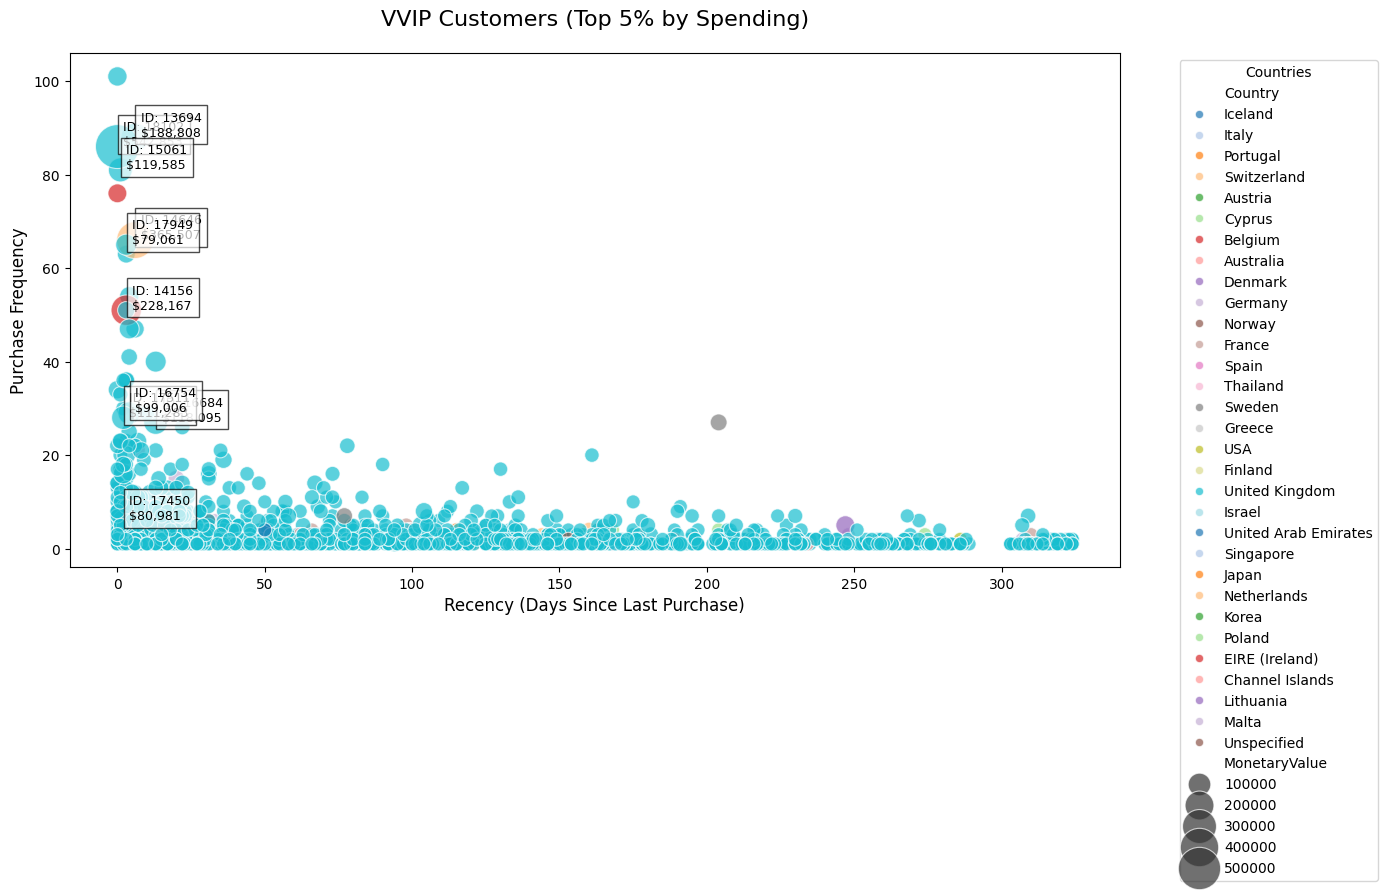

Top 10 VVIP Customers:


,CustomerID,Country,Recency,Frequency,MonetaryValue
1802,18102,United Kingdom,0.00,86,"542,852.76"
735,14646,Netherlands,6.00,66,"365,507.22"
568,14156,EIRE (Ireland),3.00,51,"228,166.56"
419,13694,United Kingdom,6.00,88,"188,808.01"
865,15061,United Kingdom,1.00,81,"119,584.71"
1347,16684,United Kingdom,13.00,27,"118,094.83"
1608,17511,United Kingdom,2.00,28,"111,283.02"
1374,16754,United Kingdom,4.00,29,"99,005.92"
1591,17450,United Kingdom,2.00,6,"80,981.20"
1747,17949,United Kingdom,3.00,65,"79,061.10"


In [ ]:
# 1. Calculate top 5% threshold based on spending
top_threshold = merged_df['SalesLineTotalUSD'].quantile(0.95)

# 2. Filter VVIP customers (top 5% spenders)
vvip_customers = merged_df[merged_df['SalesLineTotalUSD'] > top_threshold].copy()

# 3. Aggregate by customer to get RFM metrics
vvip_agg = vvip_customers.groupby(['CustomerID', 'Country']).agg({
    'InvoiceDate': lambda x: (merged_df['InvoiceDate'].max() - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'SalesLineTotalUSD': 'sum'  # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'SalesLineTotalUSD': 'MonetaryValue'
}).reset_index()

# 4. Create visualization
plt.figure(figsize=(14, 8))

# Bubble plot showing RFM dimensions
sns.scatterplot(
    data=vvip_agg,
    x='Recency',
    y='Frequency',
    size='MonetaryValue',
    hue='Country',
    sizes=(100, 1000),
    alpha=0.7,
    palette='tab20'
)

# Highlight top customers
top_10 = vvip_agg.nlargest(10, 'MonetaryValue')
for _, row in top_10.iterrows():
    plt.text(
        row['Recency'] + 2, 
        row['Frequency'] + 0.3,
        f"ID: {row['CustomerID']}\n${row['MonetaryValue']:,.0f}",
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.7)
    )

# Customize plot
plt.title('VVIP Customers (Top 5% by Spending)', fontsize=16, pad=20)
plt.xlabel('Recency (Days Since Last Purchase)', fontsize=12)
plt.ylabel('Purchase Frequency', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), title='Countries')

plt.tight_layout()
plt.show()

# 5. Display the data
print("Top 10 VVIP Customers:")
display(vvip_agg.sort_values('MonetaryValue', ascending=False).head(10))

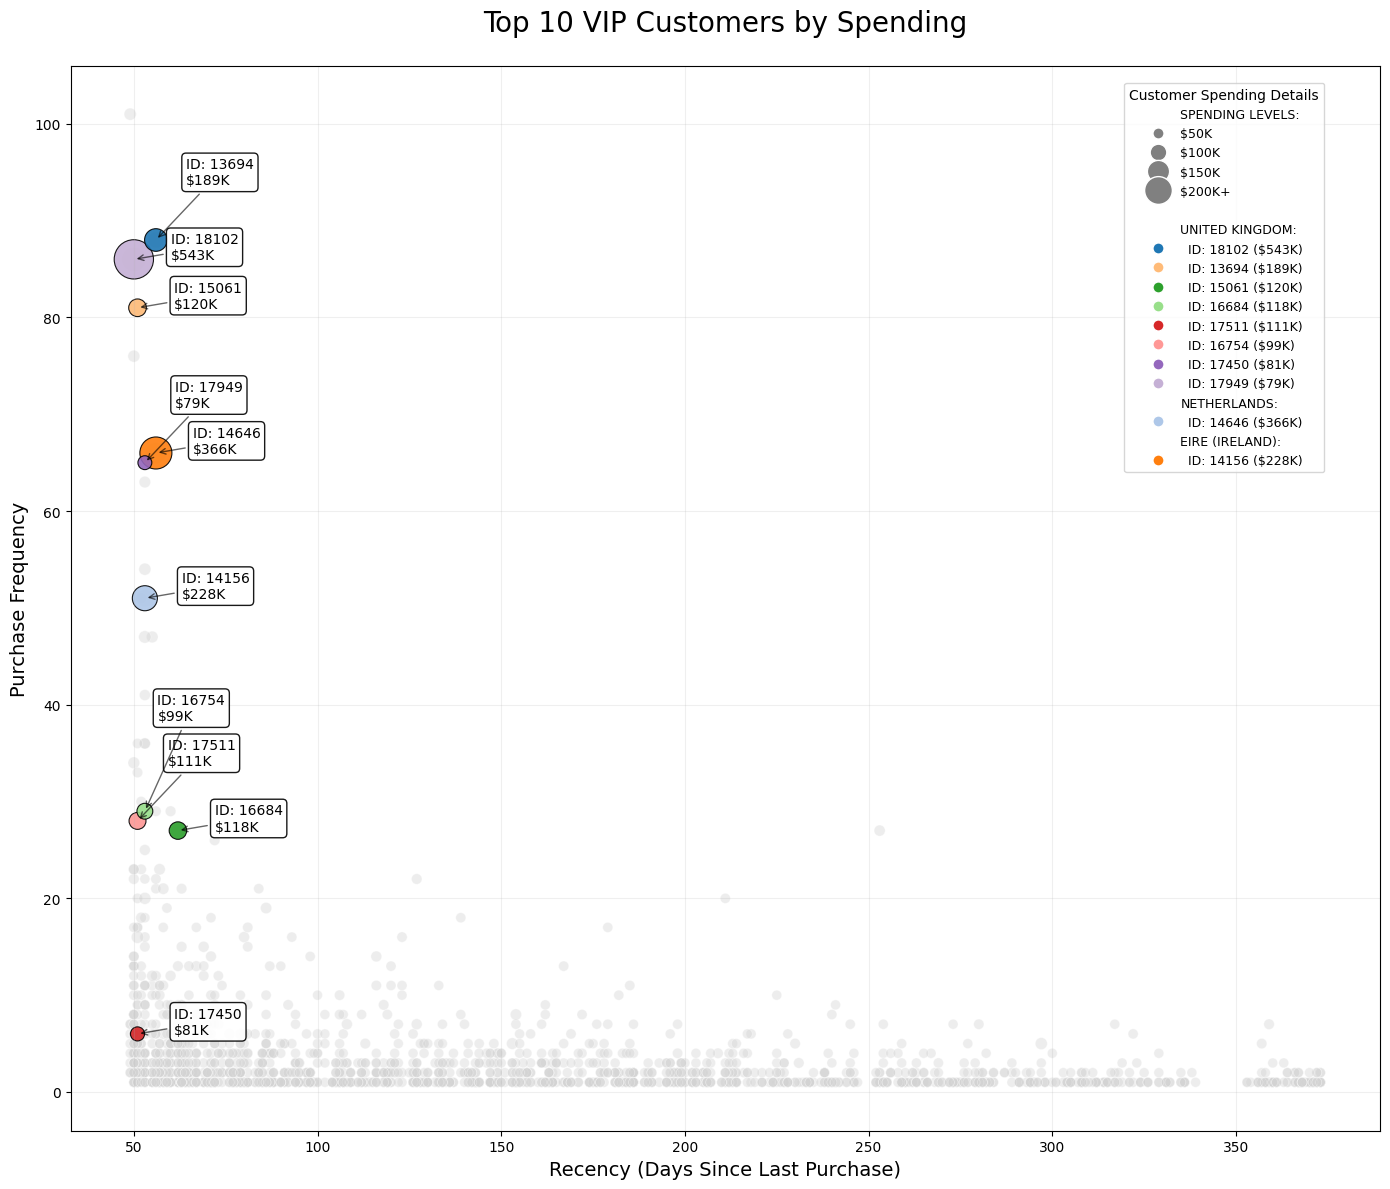

Top 10 VIP Customers:


,CustomerID,Country,Recency,Frequency,MonetaryValue
1802,18102,United Kingdom,50.000000,86,"$542,853"
735,14646,Netherlands,56.000000,66,"$365,507"
568,14156,EIRE (Ireland),53.000000,51,"$228,167"
419,13694,United Kingdom,56.000000,88,"$188,808"
865,15061,United Kingdom,51.000000,81,"$119,585"
1347,16684,United Kingdom,62.000000,27,"$118,095"
1608,17511,United Kingdom,51.000000,28,"$111,283"
1374,16754,United Kingdom,53.000000,29,"$99,006"
1591,17450,United Kingdom,51.000000,6,"$80,981"
1747,17949,United Kingdom,53.000000,65,"$79,061"


In [ ]:
# 1. Calculate top 5% threshold
top_threshold = merged_df['SalesLineTotalUSD'].quantile(0.95)

# 2. Filter VVIP customers
vvip_customers = merged_df[merged_df['SalesLineTotalUSD'] > top_threshold].copy()

# 3. Aggregate RFM metrics
vvip_agg = vvip_customers.groupby(['CustomerID', 'Country']).agg({
    'InvoiceDate': lambda x: (cleaned_df['InvoiceDate'].max() - x.max()).days,
    'Invoice': 'nunique',
    'SalesLineTotalUSD': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'SalesLineTotalUSD': 'MonetaryValue'
}).reset_index()

# 4. Create visualization
plt.figure(figsize=(14, 12))  # Slightly wider to accommodate legend

# Plot all customers in light gray
sns.scatterplot(
    data=vvip_agg,
    x='Recency',
    y='Frequency',
    size='MonetaryValue',
    sizes=(50, 300),
    alpha=0.4,
    color='lightgray',
    legend=False
)

# Highlight top 10 customers with distinct colors
top_10 = vvip_agg.nlargest(10, 'MonetaryValue')
scatter = sns.scatterplot(
    data=top_10,
    x='Recency',
    y='Frequency',
    size='MonetaryValue',
    hue='CustomerID',
    sizes=(100, 800),
    alpha=0.9,
    palette='tab20',
    edgecolor='black',
    linewidth=0.8,
    legend=False  # We'll create our own legend
)

# Custom label positioning with arrows
label_positions = {}
for idx, row in top_10.iterrows():
    x, y = row['Recency'], row['Frequency']
    
    # Find non-overlapping position
    for angle in range(0, 360, 35):
        r = 10  # Distance from point
        rad = np.deg2rad(angle)
        x_text = x + r * np.cos(rad)
        y_text = y + r * np.sin(rad)
        
        overlap = False
        for (existing_x, existing_y), _ in label_positions.items():
            if abs(x_text - existing_x) < 15 and abs(y_text - existing_y) < 4:
                overlap = True
                break
                
        if not overlap:
            label_positions[(x_text, y_text)] = (x, y, row['CustomerID'], row['MonetaryValue'])
            break
    else:
        x_text = x + 25
        y_text = y + 35
        label_positions[(x_text, y_text)] = (x, y, row['CustomerID'], row['MonetaryValue'])

# Add the labels
for (x_text, y_text), (x, y, cust_id, amount) in label_positions.items():
    plt.annotate(
        f"ID: {cust_id}\n${amount/1000:,.0f}K",
        xy=(x, y),
        xytext=(x_text, y_text),
        textcoords='data',
        fontsize=10,
        arrowprops=dict(arrowstyle='->', color='black', alpha=0.6, linewidth=1),
        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9)
    )

# Customize plot appearance
plt.title('Top 10 VIP Customers by Spending', fontsize=20, pad=25)
plt.xlabel('Recency (Days Since Last Purchase)', fontsize=14)
plt.ylabel('Purchase Frequency', fontsize=14)
plt.grid(True, alpha=0.2)

# Create unified legend
legend_elements = []

# 1. Add spending level markers
legend_elements.extend([
    plt.Line2D([0], [0], marker='o', color='w', label='SPENDING LEVELS:',
               markerfacecolor='grey', markersize=0),  # Header
    plt.Line2D([0], [0], marker='o', color='w', label='$50K',
               markerfacecolor='grey', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='$100K',
               markerfacecolor='grey', markersize=12),
    plt.Line2D([0], [0], marker='o', color='w', label='$150K',
               markerfacecolor='grey', markersize=16),
    plt.Line2D([0], [0], marker='o', color='w', label='$200K+',
               markerfacecolor='grey', markersize=20),
    plt.Line2D([0], [0], color='w', label=' ')  # Spacer
])

# 2. Add customer details by country
palette = sns.color_palette("tab20", len(top_10))
color_dict = dict(zip(top_10['CustomerID'], palette))

for country in top_10['Country'].unique():
    country_customers = top_10[top_10['Country'] == country]
    legend_elements.append(plt.Line2D([0], [0], color='w', 
                                    label=f"{country.upper()}:"))
    
    for _, customer in country_customers.iterrows():
        legend_elements.append(
            plt.Line2D([0], [0], marker='o', color='w',
                      label=f"  ID: {customer['CustomerID']} (${customer['MonetaryValue']/1000:,.0f}K)",
                      markerfacecolor=color_dict[customer['CustomerID']],
                      markersize=8))

# Add the unified legend
plt.legend(handles=legend_elements,
           title="Customer Spending Details",
           bbox_to_anchor=(.80, .99),
           loc='upper left',
           frameon=True,
           fontsize=9)

plt.tight_layout()
plt.show()

# Display the data table
print("Top 10 VIP Customers:")
display(top_10[['CustomerID', 'Country', 'Recency', 'Frequency', 'MonetaryValue']]
        .sort_values('MonetaryValue', ascending=False)
        .style.format({'MonetaryValue': '${:,.0f}'}))

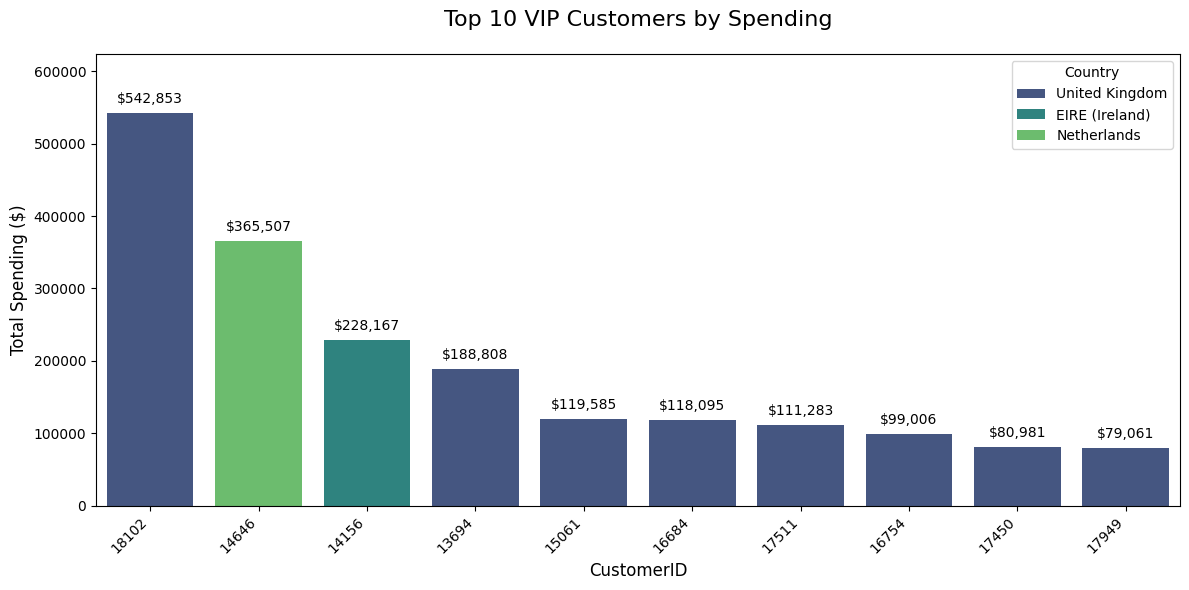

Top 10 VIP Customers Data (Ascending Order):


,CustomerID,Country,Recency,Frequency,MonetaryValue
1802,18102,United Kingdom,50.00,86,"542,852.76"
735,14646,Netherlands,56.00,66,"365,507.22"
568,14156,EIRE (Ireland),53.00,51,"228,166.56"
419,13694,United Kingdom,56.00,88,"188,808.01"
865,15061,United Kingdom,51.00,81,"119,584.71"
1347,16684,United Kingdom,62.00,27,"118,094.83"
1608,17511,United Kingdom,51.00,28,"111,283.02"
1374,16754,United Kingdom,53.00,29,"99,005.92"
1591,17450,United Kingdom,51.00,6,"80,981.20"
1747,17949,United Kingdom,53.00,65,"79,061.10"


In [ ]:
# 1. Top 10 VVIP Customers (Individuals)

# Get top 10 customers by spending (now in ascending order)
top_10_customers = vvip_agg.nlargest(10, 'MonetaryValue').sort_values('MonetaryValue', ascending=False)

# Create the plot
plt.figure(figsize=(12, 6))
bar = sns.barplot(
    data=top_10_customers,
    x='CustomerID',
    y='MonetaryValue',
    hue='Country',
    palette='viridis',
    dodge=False,
    order=top_10_customers['CustomerID']  # Ensures ascending order
)

# Add value labels (excluding zero values)
for p in bar.patches:
    if p.get_height() > 0:  # Only add label if value > 0
        bar.annotate(
            f'${p.get_height():,.0f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='bottom',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=10
        )

# Customize plot
plt.title('Top 10 VIP Customers by Spending', fontsize=16, pad=20)
plt.xlabel('CustomerID', fontsize=12)
plt.ylabel('Total Spending ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country', bbox_to_anchor=(1, 1))
plt.ylim(bottom=0, top=top_10_customers['MonetaryValue'].max() * 1.15)

plt.tight_layout()
plt.show()

# Display the data
print("Top 10 VIP Customers Data (Ascending Order):")
display(top_10_customers[['CustomerID', 'Country', 'Recency', 'Frequency', 'MonetaryValue']])

In [ ]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406309 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406309 non-null  object        
 1   StockCode    406309 non-null  object        
 2   Description  406309 non-null  object        
 3   Quantity     406309 non-null  int64         
 4   InvoiceDate  406309 non-null  datetime64[ns]
 5   Price        406309 non-null  float64       
 6   CustomerID   406309 non-null  float64       
 7   Country      406309 non-null  object        
 8   YearMonth    406309 non-null  period[M]     
dtypes: datetime64[ns](1), float64(2), int64(1), object(4), period[M](1)
memory usage: 47.1+ MB
